In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))

        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen +  air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    tf_gen_l/(index+1), \
                    tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f88bb82a430>,)

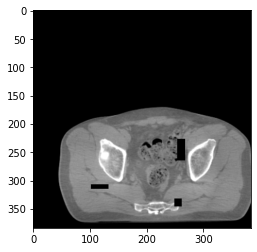

In [29]:
plt.imshow(x.squeeze(), 'gray'),

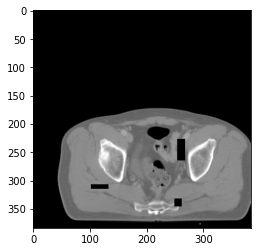

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone,loss_tf_gen, loss_tf_dis, tf_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [01:09,  4.83it/s]
336it [03:07,  1.79it/s]
336it [00:56,  5.95it/s]
48it [00:08,  5.85it/s]
336it [01:09,  4.81it/s]
336it [03:07,  1.79it/s]
336it [00:55,  6.02it/s]
48it [00:09,  4.89it/s]
336it [01:10,  4.74it/s]
336it [03:07,  1.79it/s]
336it [01:00,  5.57it/s]
48it [00:09,  5.20it/s]
336it [01:12,  4.63it/s]
336it [03:05,  1.81it/s]
336it [01:00,  5.56it/s]
48it [00:11,  4.36it/s]
336it [01:13,  4.60it/s]
336it [03:03,  1.83it/s]
336it [01:07,  4.97it/s]
48it [00:10,  4.63it/s]
336it [01:08,  4.93it/s]
336it [03:03,  1.83it/s]
336it [01:08,  4.91it/s]
48it [00:08,  5.83it/s]
336it [01:07,  4.97it/s]
336it [03:06,  1.80it/s]
336it [00:59,  5.63it/s]
48it [00:08,  5.85it/s]
336it [01:07,  4.99it/s]
336it [03:06,  1.80it/s]
336it [00:56,  5.98it/s]
48it [00:08,  5.83it/s]
336it [01:06,  5.04it/s]
336it [03:07,  1.79it/s]
336it [00:56,  5.97it/s]
48it [00:08,  5.91it/s]
336it [01:09,  4.86it/s]
336it [03:07,  1.80it/s]
336it [00:56,  5.95it/s]
48it [00:08,  5.91it/s]
336it [01:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8426780700683594
psnr score = 22.5963191986084
snr score = 12.659255027770996
mae error = 0.03539048507809639
air dice score = 0.9979136322481618
bone dice score = 0.906633134235985
contour dice score = 0.5176330208778381


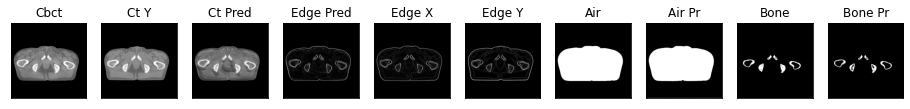

1it [00:00,  2.08it/s]

ssim score = 0.8436205387115479
psnr score = 22.454774856567383
snr score = 12.565248489379883
mae error = 0.035991083830595016
air dice score = 0.9980043452187867
bone dice score = 0.9027103243004432
contour dice score = 0.5924596190452576


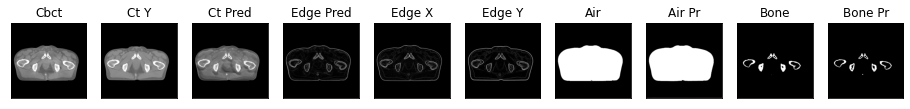

2it [00:00,  2.23it/s]

ssim score = 0.8422627449035645
psnr score = 21.869413375854492
snr score = 12.142783164978027
mae error = 0.039100710302591324
air dice score = 0.9976987529994908
bone dice score = 0.8910943496110746
contour dice score = 0.6111444234848022


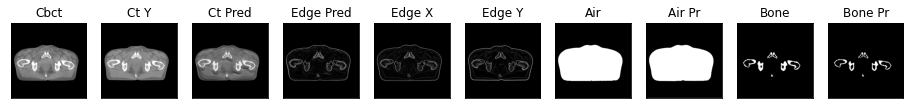

3it [00:01,  2.34it/s]

ssim score = 0.8380210995674133
psnr score = 21.6849365234375
snr score = 12.04755973815918
mae error = 0.04033977538347244
air dice score = 0.9981275991879712
bone dice score = 0.8641614982383051
contour dice score = 0.6462462544441223


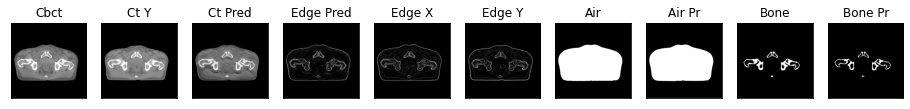

4it [00:01,  2.44it/s]

ssim score = 0.8388031721115112
psnr score = 21.54840660095215
snr score = 11.951330184936523
mae error = 0.041006118059158325
air dice score = 0.9980322941077611
bone dice score = 0.832190626055612
contour dice score = 0.609375


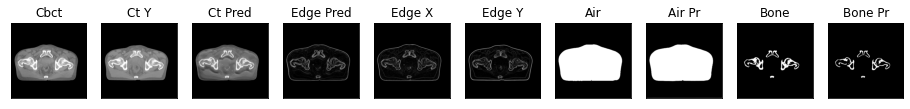

5it [00:01,  2.50it/s]

ssim score = 0.8372631072998047
psnr score = 21.119253158569336
snr score = 11.658712387084961
mae error = 0.043559152632951736
air dice score = 0.9979942807212666
bone dice score = 0.7869595193559837
contour dice score = 0.6176115870475769


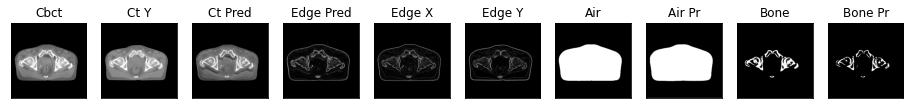

6it [00:02,  2.55it/s]

ssim score = 0.8379325866699219
psnr score = 21.13184928894043
snr score = 11.647252082824707
mae error = 0.04312409833073616
air dice score = 0.9977709139252928
bone dice score = 0.7602905569030479
contour dice score = 0.657384991645813


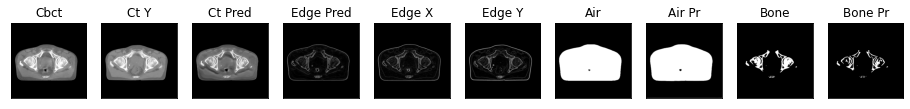

7it [00:02,  2.58it/s]

ssim score = 0.8417003750801086
psnr score = 21.745819091796875
snr score = 12.07568645477295
mae error = 0.0399661585688591
air dice score = 0.9976577029404397
bone dice score = 0.7888888888911018
contour dice score = 0.6120218634605408


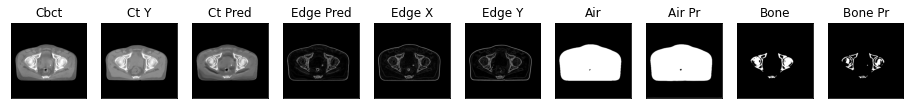

8it [00:03,  2.22it/s]

ssim score = 0.8418672680854797
psnr score = 22.072534561157227
snr score = 12.307845115661621
mae error = 0.03833882883191109
air dice score = 0.9980794112890202
bone dice score = 0.8170336425637975
contour dice score = 0.5947592854499817


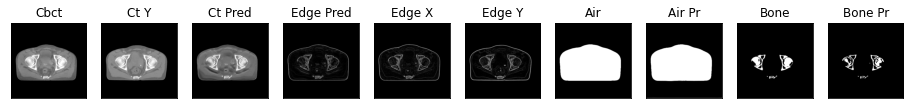

9it [00:03,  2.35it/s]

ssim score = 0.8457210659980774
psnr score = 21.99799346923828
snr score = 12.218022346496582
mae error = 0.03881135955452919
air dice score = 0.9973735646225289
bone dice score = 0.8213333333354047
contour dice score = 0.591687023639679


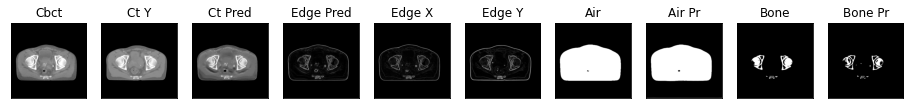

10it [00:04,  2.44it/s]

ssim score = 0.8510141968727112
psnr score = 21.97576332092285
snr score = 12.228059768676758
mae error = 0.039158694446086884
air dice score = 0.9971448161527706
bone dice score = 0.8805356513581517
contour dice score = 0.5529052019119263


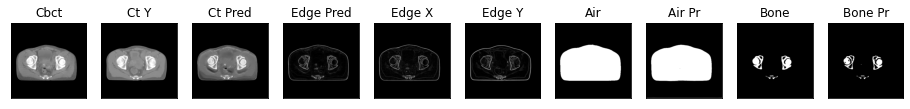

11it [00:04,  2.51it/s]

ssim score = 0.8504531383514404
psnr score = 21.43062400817871
snr score = 11.70663070678711
mae error = 0.04105746001005173
air dice score = 0.995510685396285
bone dice score = 0.8492322572863107
contour dice score = 0.5


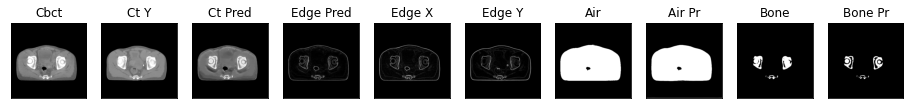

12it [00:04,  2.57it/s]

ssim score = 0.8533715605735779
psnr score = 21.242115020751953
snr score = 11.486198425292969
mae error = 0.04118095338344574
air dice score = 0.9937368212280071
bone dice score = 0.9038224414315188
contour dice score = 0.5263803601264954


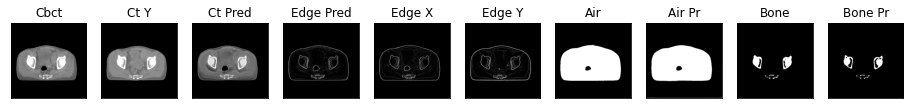

13it [00:05,  2.60it/s]

ssim score = 0.8522133231163025
psnr score = 21.36012077331543
snr score = 11.462248802185059
mae error = 0.03950311616063118
air dice score = 0.9955043373646599
bone dice score = 0.85603112840667
contour dice score = 0.5064854621887207


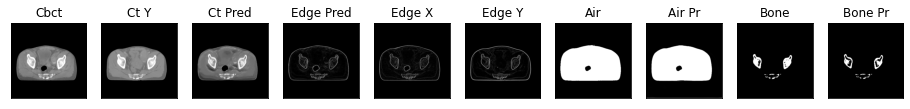

14it [00:05,  2.63it/s]

ssim score = 0.8537755012512207
psnr score = 21.402671813964844
snr score = 11.41913890838623
mae error = 0.038800109177827835
air dice score = 0.9939410659903928
bone dice score = 0.8609891717901523
contour dice score = 0.5423100590705872


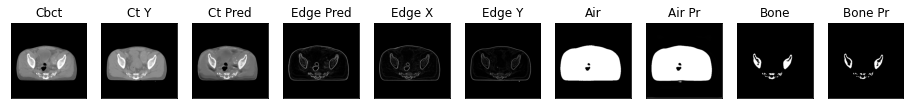

15it [00:05,  2.64it/s]

ssim score = 0.8486075401306152
psnr score = 21.218326568603516
snr score = 11.25827693939209
mae error = 0.039767585694789886
air dice score = 0.994952243743669
bone dice score = 0.8829670329686405
contour dice score = 0.5680250525474548


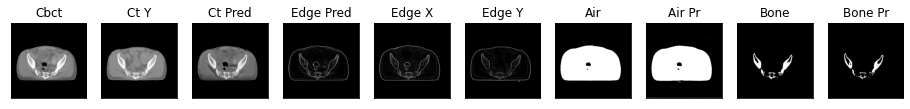

16it [00:06,  2.66it/s]

ssim score = 0.8472486138343811
psnr score = 20.919071197509766
snr score = 10.956478118896484
mae error = 0.04074253514409065
air dice score = 0.9954868384115447
bone dice score = 0.8654151242746507
contour dice score = 0.5748427510261536


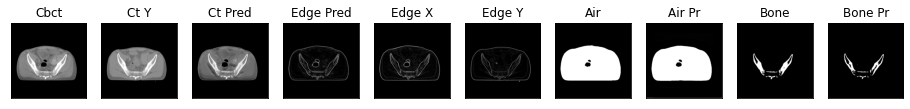

17it [00:06,  2.66it/s]

ssim score = 0.8401397466659546
psnr score = 20.640764236450195
snr score = 10.576411247253418
mae error = 0.04091058298945427
air dice score = 0.9948133346436544
bone dice score = 0.8204633204657962
contour dice score = 0.5474860072135925


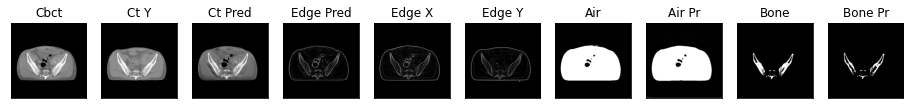

18it [00:07,  2.29it/s]

ssim score = 0.8376768231391907
psnr score = 20.524118423461914
snr score = 10.409083366394043
mae error = 0.04125255346298218
air dice score = 0.9939588674802272
bone dice score = 0.8115426695868224
contour dice score = 0.5584664344787598


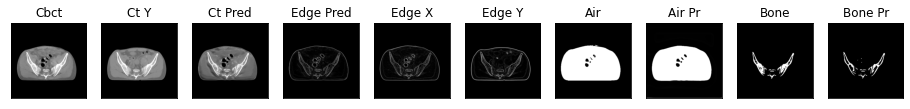

19it [00:07,  2.40it/s]

ssim score = 0.8439239263534546
psnr score = 20.568450927734375
snr score = 10.441106796264648
mae error = 0.04127701371908188
air dice score = 0.9942995030052197
bone dice score = 0.8456636187330886
contour dice score = 0.4682741165161133


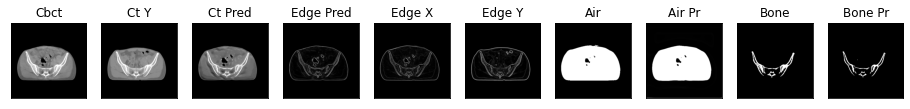

20it [00:07,  2.48it/s]

ssim score = 0.8423378467559814
psnr score = 20.618135452270508
snr score = 10.425945281982422
mae error = 0.040862102061510086
air dice score = 0.9949761086053733
bone dice score = 0.8476346813931109
contour dice score = 0.5035234093666077


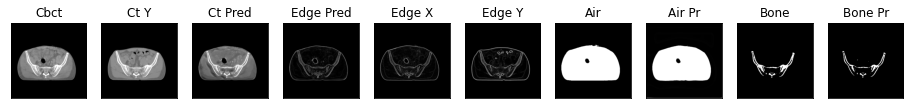

21it [00:08,  2.54it/s]

ssim score = 0.8393810987472534
psnr score = 20.597822189331055
snr score = 10.346203804016113
mae error = 0.040902625769376755
air dice score = 0.9935517268543078
bone dice score = 0.8496384831068373
contour dice score = 0.4460245668888092


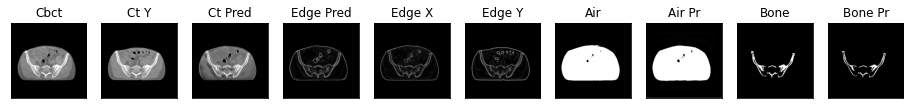

22it [00:08,  2.58it/s]

ssim score = 0.8458767533302307
psnr score = 20.83266830444336
snr score = 10.547619819641113
mae error = 0.039796605706214905
air dice score = 0.9944789039601999
bone dice score = 0.849208553181766
contour dice score = 0.4847303330898285


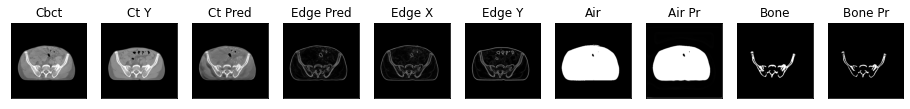

23it [00:09,  2.62it/s]

ssim score = 0.8429155349731445
psnr score = 20.802085876464844
snr score = 10.46847152709961
mae error = 0.03941832482814789
air dice score = 0.9942597354886179
bone dice score = 0.8396595974626548
contour dice score = 0.42809808254241943


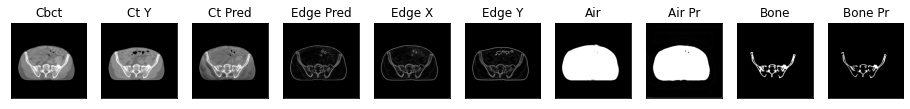

24it [00:09,  2.64it/s]

ssim score = 0.8400148749351501
psnr score = 20.76695442199707
snr score = 10.336341857910156
mae error = 0.03911953046917915
air dice score = 0.9943950499318382
bone dice score = 0.8305283757360662
contour dice score = 0.42367181181907654


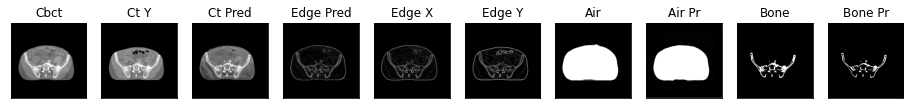

25it [00:09,  2.66it/s]

ssim score = 0.8432678580284119
psnr score = 20.869770050048828
snr score = 10.356420516967773
mae error = 0.038214921951293945
air dice score = 0.9900515231379371
bone dice score = 0.8201588748558385
contour dice score = 0.4125255346298218


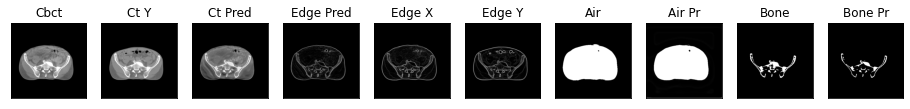

26it [00:10,  2.67it/s]

ssim score = 0.8420398831367493
psnr score = 21.026914596557617
snr score = 10.422380447387695
mae error = 0.03726767748594284
air dice score = 0.9899149070280614
bone dice score = 0.8057813911497512
contour dice score = 0.48011165857315063


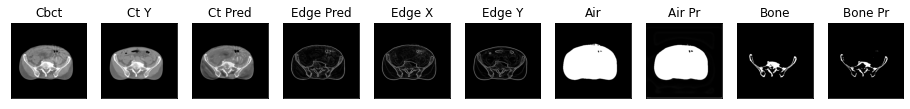

27it [00:10,  2.68it/s]

ssim score = 0.8407979011535645
psnr score = 20.970314025878906
snr score = 10.324670791625977
mae error = 0.03738376498222351
air dice score = 0.9900221184566355
bone dice score = 0.8339154522481763
contour dice score = 0.45795053243637085


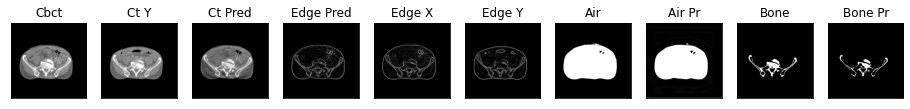

28it [00:11,  2.30it/s]

ssim score = 0.8115069270133972
psnr score = 21.62075424194336
snr score = 12.992911338806152
mae error = 0.04459964856505394
air dice score = 0.9963217081145371
bone dice score = 0.969387755103017
contour dice score = 0.3993217349052429


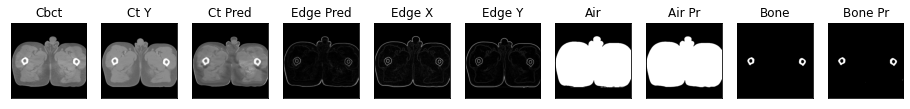

29it [00:11,  2.40it/s]

ssim score = 0.8177055716514587
psnr score = 22.01166343688965
snr score = 13.423078536987305
mae error = 0.04357876256108284
air dice score = 0.995768376896567
bone dice score = 0.9738817172028256
contour dice score = 0.37605395913124084


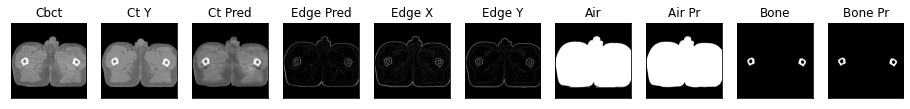

30it [00:11,  2.49it/s]

ssim score = 0.8253217935562134
psnr score = 22.22057342529297
snr score = 13.719439506530762
mae error = 0.04408716410398483
air dice score = 0.9962193852391673
bone dice score = 0.9627166943727685
contour dice score = 0.37599998712539673


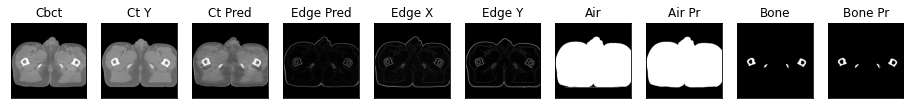

31it [00:12,  2.56it/s]

ssim score = 0.828988790512085
psnr score = 22.033369064331055
snr score = 13.694791793823242
mae error = 0.04752876237034798
air dice score = 0.9975863383118901
bone dice score = 0.9344124093755789
contour dice score = 0.3641379177570343


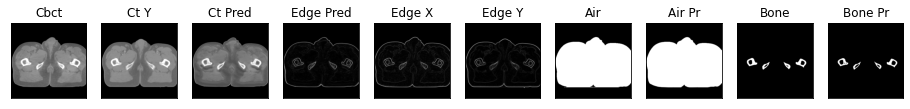

32it [00:12,  2.61it/s]

ssim score = 0.8292537331581116
psnr score = 21.847393035888672
snr score = 13.636956214904785
mae error = 0.049953922629356384
air dice score = 0.997608937874546
bone dice score = 0.9233485361200037
contour dice score = 0.34309622645378113


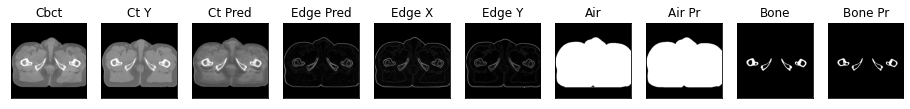

33it [00:12,  2.65it/s]

ssim score = 0.8300350904464722
psnr score = 21.71879768371582
snr score = 13.61159896850586
mae error = 0.05194850638508797
air dice score = 0.9981827886697184
bone dice score = 0.9033690258565765
contour dice score = 0.3147113621234894


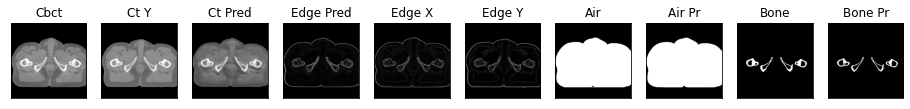

34it [00:13,  2.67it/s]

ssim score = 0.828885018825531
psnr score = 21.59562110900879
snr score = 13.555526733398438
mae error = 0.053347837179899216
air dice score = 0.9977708319637609
bone dice score = 0.8786909448833823
contour dice score = 0.3179916441440582


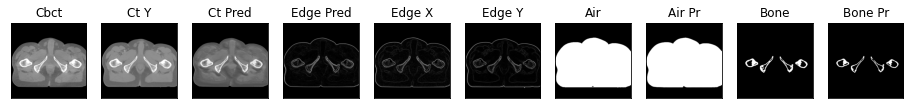

35it [00:13,  2.69it/s]

ssim score = 0.829519510269165
psnr score = 21.7099609375
snr score = 13.659975051879883
mae error = 0.05239098146557808
air dice score = 0.9980577434076486
bone dice score = 0.8778785764145396
contour dice score = 0.32437440752983093


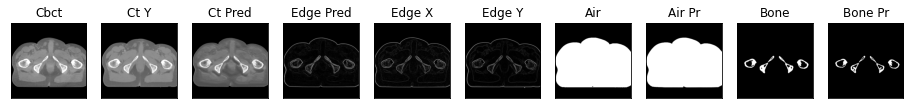

36it [00:14,  2.70it/s]

ssim score = 0.8348063230514526
psnr score = 21.844337463378906
snr score = 13.780685424804688
mae error = 0.05159284546971321
air dice score = 0.9980382132283888
bone dice score = 0.8766712770876363
contour dice score = 0.3337969481945038


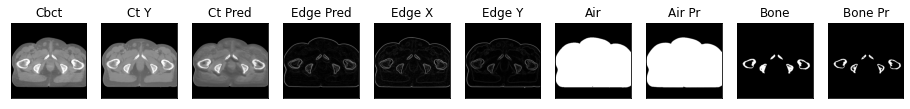

37it [00:14,  2.71it/s]

ssim score = 0.8349612951278687
psnr score = 21.890003204345703
snr score = 13.838354110717773
mae error = 0.051415786147117615
air dice score = 0.9980763293514154
bone dice score = 0.8751982432612516
contour dice score = 0.3483511507511139


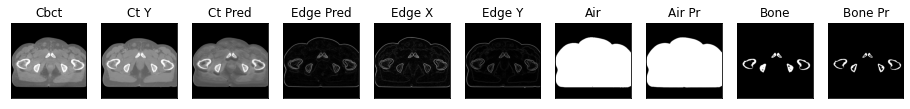

38it [00:15,  2.31it/s]

ssim score = 0.8357360363006592
psnr score = 21.738740921020508
snr score = 13.726176261901855
mae error = 0.052716560661792755
air dice score = 0.9980301412127697
bone dice score = 0.8870251603368645
contour dice score = 0.3628731369972229


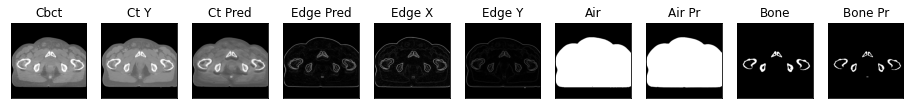

39it [00:15,  2.40it/s]

ssim score = 0.8321764469146729
psnr score = 21.217174530029297
snr score = 13.345898628234863
mae error = 0.05669822916388512
air dice score = 0.9982550686102285
bone dice score = 0.8714209115295289
contour dice score = 0.3217960596084595


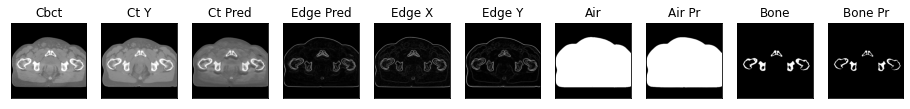

40it [00:15,  2.49it/s]

ssim score = 0.8320117592811584
psnr score = 20.927837371826172
snr score = 13.151246070861816
mae error = 0.05921775847673416
air dice score = 0.9980272383714033
bone dice score = 0.8334859864459289
contour dice score = 0.33723652362823486


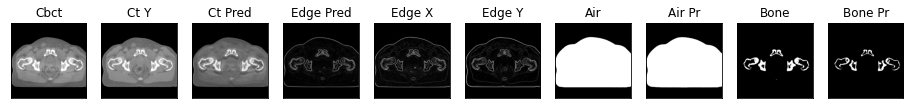

41it [00:16,  2.56it/s]

ssim score = 0.8208003044128418
psnr score = 20.675382614135742
snr score = 12.864747047424316
mae error = 0.06012576073408127
air dice score = 0.9979489136397255
bone dice score = 0.8095927601827186
contour dice score = 0.3308270573616028


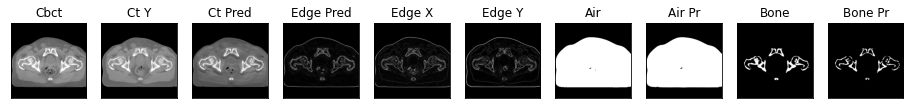

42it [00:16,  2.61it/s]

ssim score = 0.8179919123649597
psnr score = 20.18701171875
snr score = 12.448559761047363
mae error = 0.06255272775888443
air dice score = 0.9972033511774748
bone dice score = 0.7283748361752264
contour dice score = 0.3171764612197876


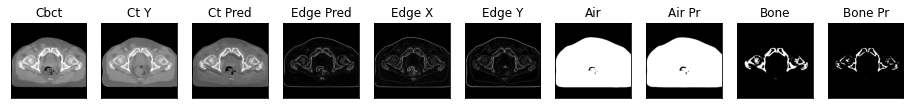

43it [00:16,  2.65it/s]

ssim score = 0.8204466700553894
psnr score = 20.53970718383789
snr score = 12.665163040161133
mae error = 0.059860099107027054
air dice score = 0.997717843572931
bone dice score = 0.7959839357450201
contour dice score = 0.317430317401886


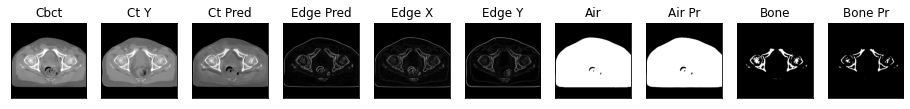

44it [00:17,  2.68it/s]

ssim score = 0.824402928352356
psnr score = 21.132762908935547
snr score = 13.079657554626465
mae error = 0.05559544637799263
air dice score = 0.9971448060218654
bone dice score = 0.8246810382773352
contour dice score = 0.4227488040924072


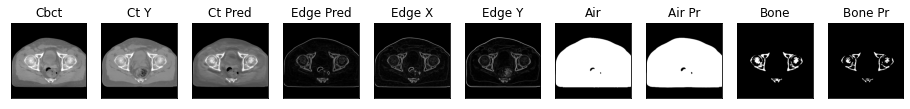

45it [00:17,  2.70it/s]

ssim score = 0.824904203414917
psnr score = 21.600971221923828
snr score = 13.45727825164795
mae error = 0.05294988676905632
air dice score = 0.9975033701480462
bone dice score = 0.8495875788470452
contour dice score = 0.3876190483570099


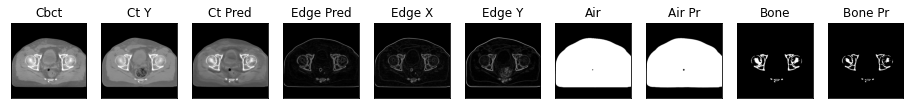

46it [00:17,  2.71it/s]

ssim score = 0.8274022340774536
psnr score = 21.602354049682617
snr score = 13.474349975585938
mae error = 0.05292176455259323
air dice score = 0.9975534982546683
bone dice score = 0.8351926394498539
contour dice score = 0.4284351170063019


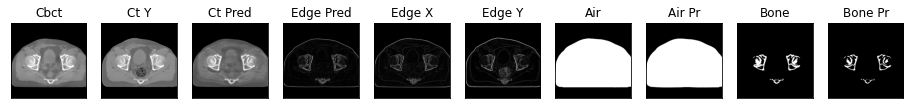

47it [00:18,  2.72it/s]

ssim score = 0.8140854239463806
psnr score = 21.366518020629883
snr score = 13.248549461364746
mae error = 0.05386372283101082
air dice score = 0.9975772444053889
bone dice score = 0.8166772756225685
contour dice score = 0.4204491078853607


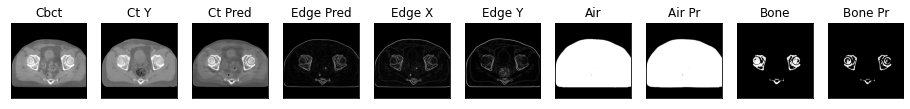

48it [00:18,  2.33it/s]

ssim score = 0.8230635523796082
psnr score = 21.422382354736328
snr score = 13.366003036499023
mae error = 0.05339256301522255
air dice score = 0.998149623184855
bone dice score = 0.8305899192328944
contour dice score = 0.3904534578323364


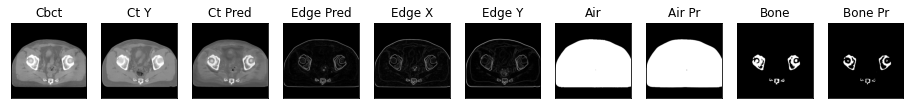

49it [00:19,  2.43it/s]

ssim score = 0.8223011493682861
psnr score = 21.336238861083984
snr score = 13.34994125366211
mae error = 0.05450001358985901
air dice score = 0.9977644847874432
bone dice score = 0.8727518855166047
contour dice score = 0.36545801162719727


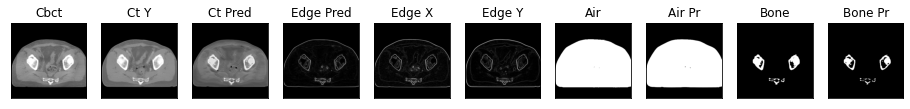

50it [00:19,  2.51it/s]

ssim score = 0.8314889669418335
psnr score = 21.7025203704834
snr score = 13.59711742401123
mae error = 0.05194347724318504
air dice score = 0.997409135559923
bone dice score = 0.859861591697017
contour dice score = 0.3854961693286896


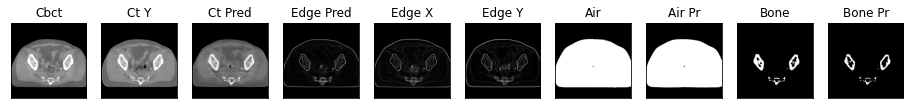

51it [00:20,  2.57it/s]

ssim score = 0.8238908052444458
psnr score = 21.21503448486328
snr score = 13.19125747680664
mae error = 0.054475102573633194
air dice score = 0.9976624476198087
bone dice score = 0.8394398618852922
contour dice score = 0.3536176383495331


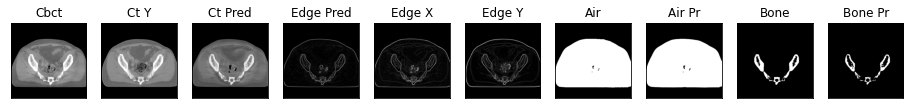

52it [00:20,  2.63it/s]

ssim score = 0.8259660005569458
psnr score = 21.082828521728516
snr score = 13.139198303222656
mae error = 0.056498441845178604
air dice score = 0.9966974455752531
bone dice score = 0.7963055416891637
contour dice score = 0.29807692766189575


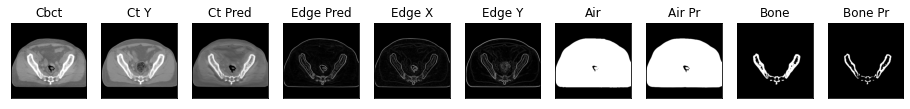

53it [00:20,  2.66it/s]

ssim score = 0.8067205548286438
psnr score = 20.89512062072754
snr score = 12.973050117492676
mae error = 0.05702090263366699
air dice score = 0.9969694377573858
bone dice score = 0.7815665091173062
contour dice score = 0.2915057837963104


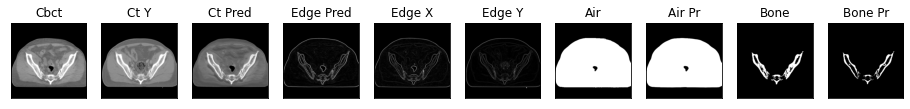

54it [00:21,  2.69it/s]

ssim score = 0.8094536662101746
psnr score = 21.03345489501953
snr score = 13.123920440673828
mae error = 0.056589558720588684
air dice score = 0.9968181239658922
bone dice score = 0.7917694073650899
contour dice score = 0.27649325132369995


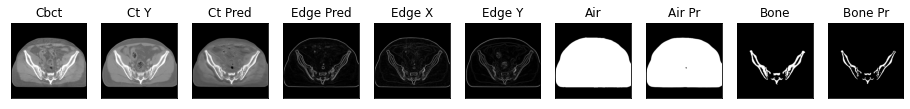

55it [00:21,  2.70it/s]

ssim score = 0.7721924185752869
psnr score = 19.978271484375
snr score = 9.858479499816895
mae error = 0.04448041319847107
air dice score = 0.9964524467421371
bone dice score = 0.959166895040856
contour dice score = 0.5082873106002808


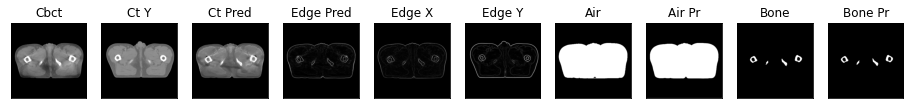

56it [00:21,  2.72it/s]

ssim score = 0.7640282511711121
psnr score = 19.55802345275879
snr score = 9.651212692260742
mae error = 0.047976769506931305
air dice score = 0.9966766809347861
bone dice score = 0.9422865920574438
contour dice score = 0.5536598563194275


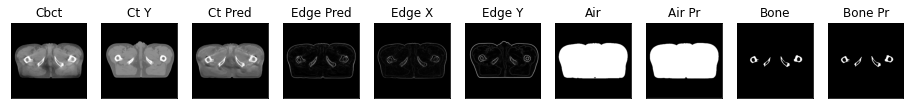

57it [00:22,  2.73it/s]

ssim score = 0.7605955600738525
psnr score = 19.413593292236328
snr score = 9.637923240661621
mae error = 0.0495605394244194
air dice score = 0.9972317240892926
bone dice score = 0.9293511843474902
contour dice score = 0.5731506943702698


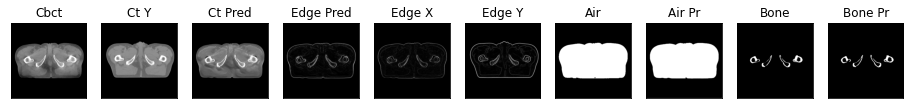

58it [00:22,  2.32it/s]

ssim score = 0.7672687768936157
psnr score = 19.63397216796875
snr score = 9.928703308105469
mae error = 0.04881950840353966
air dice score = 0.9968594287318436
bone dice score = 0.9222466520103488
contour dice score = 0.51722252368927


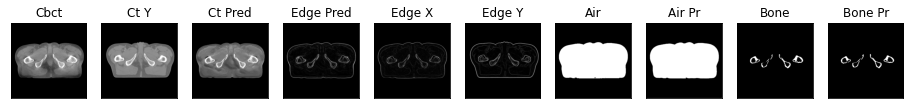

59it [00:23,  2.43it/s]

ssim score = 0.7680539488792419
psnr score = 19.65514373779297
snr score = 9.997440338134766
mae error = 0.04900410398840904
air dice score = 0.9961526354447238
bone dice score = 0.9086623453170564
contour dice score = 0.5476319789886475


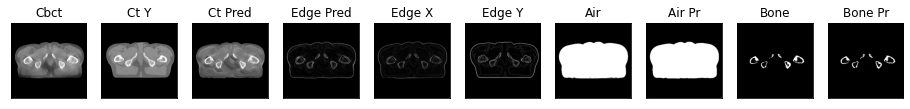

60it [00:23,  2.52it/s]

ssim score = 0.7671841979026794
psnr score = 19.708084106445312
snr score = 10.055994987487793
mae error = 0.04860973358154297
air dice score = 0.9959308860560998
bone dice score = 0.9011161151380239
contour dice score = 0.512738823890686


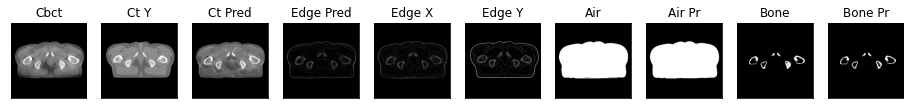

61it [00:23,  2.58it/s]

ssim score = 0.7685742974281311
psnr score = 19.80288314819336
snr score = 10.144291877746582
mae error = 0.04831481724977493
air dice score = 0.9955875966299005
bone dice score = 0.9231371015074684
contour dice score = 0.5401382446289062


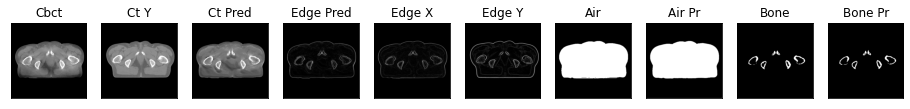

62it [00:24,  2.63it/s]

ssim score = 0.7693330645561218
psnr score = 19.819522857666016
snr score = 10.175041198730469
mae error = 0.04882039129734039
air dice score = 0.995612858564448
bone dice score = 0.9372035666868298
contour dice score = 0.5347480177879333


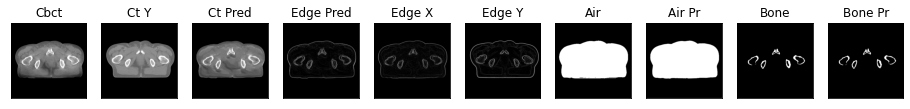

63it [00:24,  2.66it/s]

ssim score = 0.7724340558052063
psnr score = 19.703914642333984
snr score = 10.117441177368164
mae error = 0.05042603611946106
air dice score = 0.9950799401637757
bone dice score = 0.92276559865223
contour dice score = 0.5090715289115906


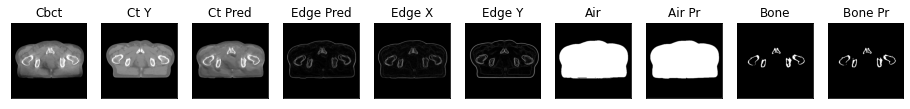

64it [00:24,  2.69it/s]

ssim score = 0.7609557509422302
psnr score = 19.4363956451416
snr score = 9.948481559753418
mae error = 0.05291885510087013
air dice score = 0.9951374280097983
bone dice score = 0.8934041888106689
contour dice score = 0.46705323457717896


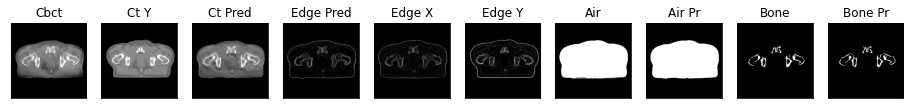

65it [00:25,  2.71it/s]

ssim score = 0.7494506239891052
psnr score = 19.238441467285156
snr score = 9.786355972290039
mae error = 0.05444483086466789
air dice score = 0.9952917480784004
bone dice score = 0.8864249325758702
contour dice score = 0.46269458532333374


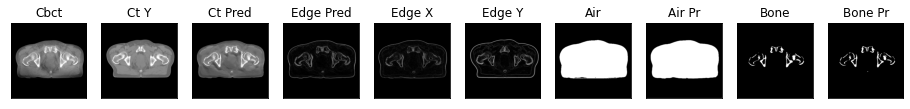

66it [00:25,  2.71it/s]

ssim score = 0.7408228516578674
psnr score = 19.150083541870117
snr score = 9.730704307556152
mae error = 0.055095870047807693
air dice score = 0.9957348009287164
bone dice score = 0.8557866815600197
contour dice score = 0.4507494568824768


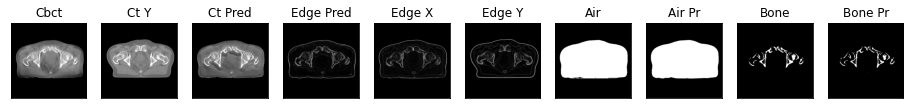

67it [00:26,  2.72it/s]

ssim score = 0.7397420406341553
psnr score = 19.116939544677734
snr score = 9.814377784729004
mae error = 0.055000219494104385
air dice score = 0.9963449978070018
bone dice score = 0.8712141882691512
contour dice score = 0.48919346928596497


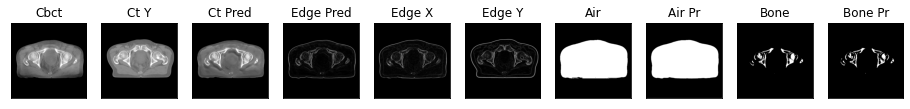

68it [00:26,  2.32it/s]

ssim score = 0.7403172850608826
psnr score = 19.188865661621094
snr score = 9.870320320129395
mae error = 0.05361216142773628
air dice score = 0.9965684208715725
bone dice score = 0.8695127470226351
contour dice score = 0.4537540674209595


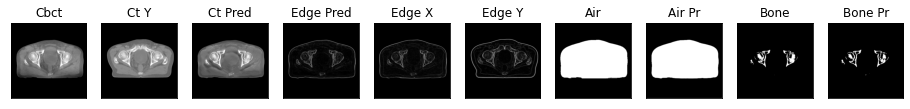

69it [00:27,  2.44it/s]

ssim score = 0.7589870095252991
psnr score = 19.83380126953125
snr score = 10.31608772277832
mae error = 0.048495352268218994
air dice score = 0.997017798671333
bone dice score = 0.8993288590620113
contour dice score = 0.46673819422721863


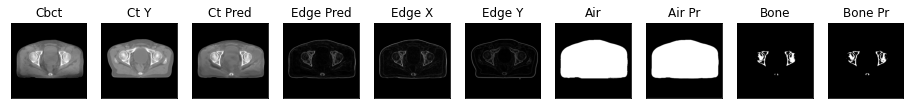

70it [00:27,  2.53it/s]

ssim score = 0.7749264240264893
psnr score = 20.552104949951172
snr score = 10.86400032043457
mae error = 0.04437774419784546
air dice score = 0.9968841469171965
bone dice score = 0.905790579059319
contour dice score = 0.45425188541412354


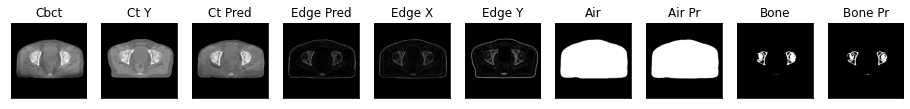

71it [00:27,  2.58it/s]

ssim score = 0.7839566469192505
psnr score = 20.83761978149414
snr score = 11.16368293762207
mae error = 0.043281156569719315
air dice score = 0.9968903394926911
bone dice score = 0.869080779946209
contour dice score = 0.46367520093917847


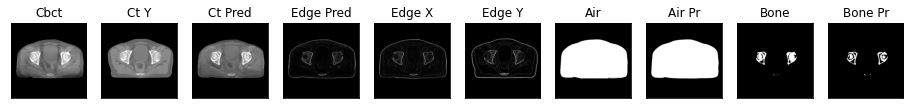

72it [00:28,  2.63it/s]

ssim score = 0.7904837727546692
psnr score = 20.89321517944336
snr score = 11.301108360290527
mae error = 0.04340365529060364
air dice score = 0.9972059640278573
bone dice score = 0.877665876779063
contour dice score = 0.4918566644191742


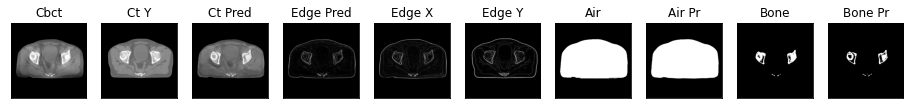

73it [00:28,  2.67it/s]

ssim score = 0.7878748178482056
psnr score = 20.720733642578125
snr score = 11.220799446105957
mae error = 0.04386921599507332
air dice score = 0.9968473074301322
bone dice score = 0.8896878574948572
contour dice score = 0.5016501545906067


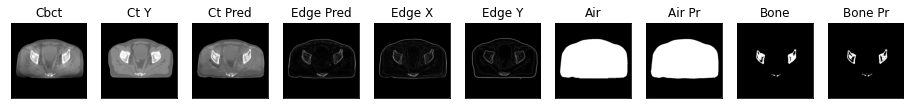

74it [00:28,  2.70it/s]

ssim score = 0.7823877930641174
psnr score = 20.876062393188477
snr score = 11.312700271606445
mae error = 0.04328234866261482
air dice score = 0.9966293947343873
bone dice score = 0.9131049099273559
contour dice score = 0.49865952134132385


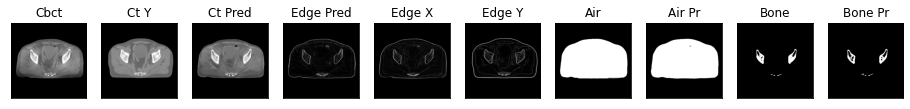

75it [00:29,  2.72it/s]

ssim score = 0.7845618724822998
psnr score = 21.004127502441406
snr score = 11.404372215270996
mae error = 0.04289722070097923
air dice score = 0.996214307540831
bone dice score = 0.8967619047638712
contour dice score = 0.5082578659057617


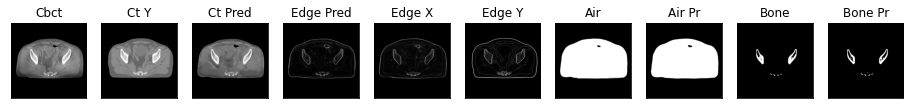

76it [00:29,  2.73it/s]

ssim score = 0.7805121541023254
psnr score = 20.70132064819336
snr score = 11.139311790466309
mae error = 0.04461600258946419
air dice score = 0.9962817704884664
bone dice score = 0.8793978645216279
contour dice score = 0.5577942728996277


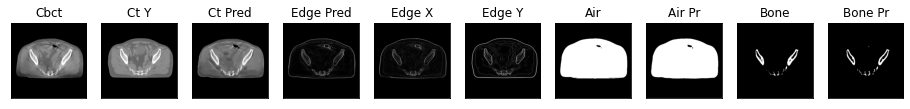

77it [00:29,  2.73it/s]

ssim score = 0.7811108827590942
psnr score = 20.476951599121094
snr score = 11.045446395874023
mae error = 0.046011440455913544
air dice score = 0.9963960900977507
bone dice score = 0.8782636049091183
contour dice score = 0.5705128312110901


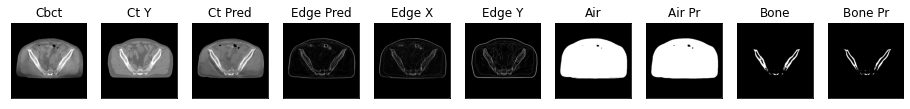

78it [00:30,  2.33it/s]

ssim score = 0.7825295925140381
psnr score = 20.45156478881836
snr score = 11.037808418273926
mae error = 0.04601769894361496
air dice score = 0.9963151250469171
bone dice score = 0.8622895622918807
contour dice score = 0.5553168654441833


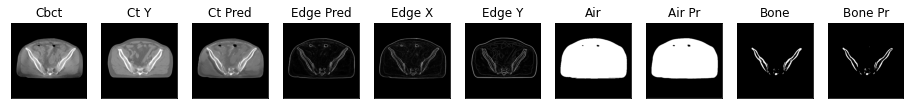

79it [00:30,  2.44it/s]

ssim score = 0.7850579023361206
psnr score = 20.705291748046875
snr score = 11.280265808105469
mae error = 0.04491034895181656
air dice score = 0.9962065097320613
bone dice score = 0.8962043533028206
contour dice score = 0.5607779622077942


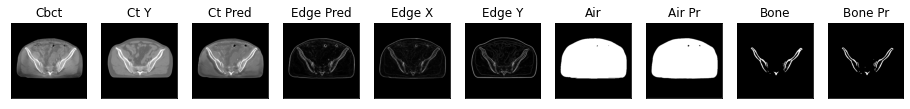

80it [00:31,  2.53it/s]

ssim score = 0.7855083346366882
psnr score = 20.60077476501465
snr score = 11.175008773803711
mae error = 0.04544131085276604
air dice score = 0.9962951820174528
bone dice score = 0.8718037318612335
contour dice score = 0.5454545617103577


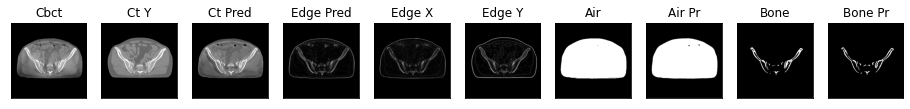

81it [00:31,  2.59it/s]

ssim score = 0.8221583962440491
psnr score = 22.146053314208984
snr score = 12.58018684387207
mae error = 0.035767197608947754
air dice score = 0.9968123426094189
bone dice score = 0.9563898369375659
contour dice score = 0.43607425689697266


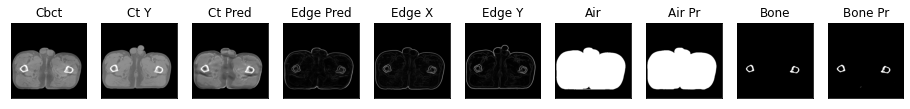

82it [00:31,  2.64it/s]

ssim score = 0.825077474117279
psnr score = 22.32105255126953
snr score = 12.819580078125
mae error = 0.03602812811732292
air dice score = 0.9964603872193876
bone dice score = 0.9376313945361727
contour dice score = 0.3905511796474457


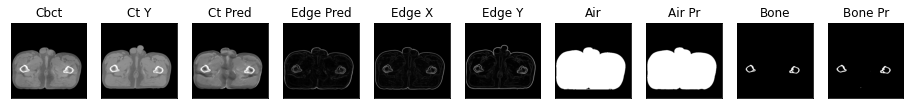

83it [00:32,  2.67it/s]

ssim score = 0.8363701105117798
psnr score = 22.723329544067383
snr score = 13.361067771911621
mae error = 0.03809531033039093
air dice score = 0.9972222874267449
bone dice score = 0.9503091367082594
contour dice score = 0.47512689232826233


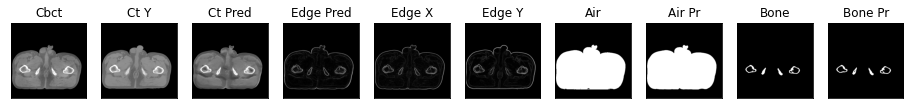

84it [00:32,  2.70it/s]

ssim score = 0.8349599838256836
psnr score = 22.527278900146484
snr score = 13.286510467529297
mae error = 0.03997218236327171
air dice score = 0.9980623020474245
bone dice score = 0.9382022471923466
contour dice score = 0.5413456559181213


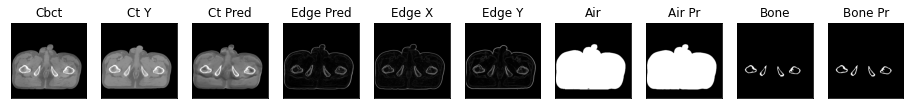

85it [00:33,  2.72it/s]

ssim score = 0.829346239566803
psnr score = 22.427566528320312
snr score = 13.210968971252441
mae error = 0.04037993401288986
air dice score = 0.9983776440908222
bone dice score = 0.9126846220696637
contour dice score = 0.5179034471511841


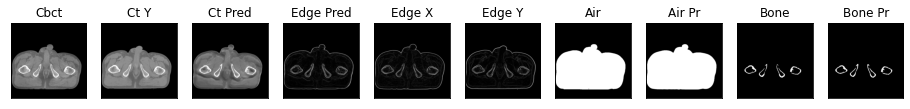

86it [00:33,  2.73it/s]

ssim score = 0.8286802768707275
psnr score = 22.393827438354492
snr score = 13.172835350036621
mae error = 0.04063892364501953
air dice score = 0.9983403390671788
bone dice score = 0.9213798636197076
contour dice score = 0.5104602575302124


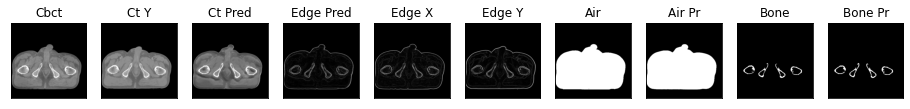

87it [00:33,  2.74it/s]

ssim score = 0.8278578519821167
psnr score = 22.200632095336914
snr score = 12.985893249511719
mae error = 0.04118645191192627
air dice score = 0.9982796032238079
bone dice score = 0.9224667856450036
contour dice score = 0.497103750705719


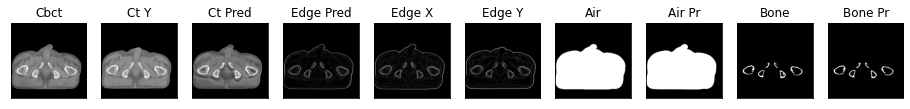

88it [00:34,  2.33it/s]

ssim score = 0.8247845768928528
psnr score = 22.136959075927734
snr score = 12.900666236877441
mae error = 0.04100784286856651
air dice score = 0.9982311595214834
bone dice score = 0.9318672688016519
contour dice score = 0.49367088079452515


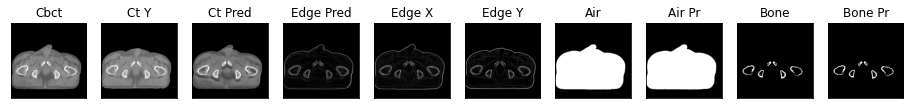

89it [00:34,  2.44it/s]

ssim score = 0.8261997103691101
psnr score = 22.0765323638916
snr score = 12.857149124145508
mae error = 0.041317299008369446
air dice score = 0.9980163206248216
bone dice score = 0.9312326228001625
contour dice score = 0.5021186470985413


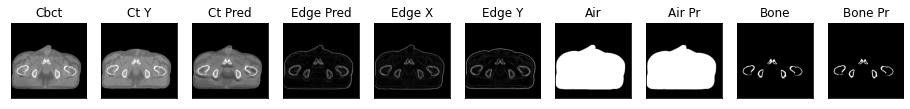

90it [00:35,  2.53it/s]

ssim score = 0.8241894841194153
psnr score = 21.952306747436523
snr score = 12.801515579223633
mae error = 0.042519595474004745
air dice score = 0.9980943157500132
bone dice score = 0.9359104781292656
contour dice score = 0.5357524156570435


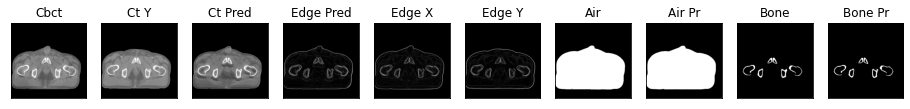

91it [00:35,  2.59it/s]

ssim score = 0.8244752883911133
psnr score = 21.859416961669922
snr score = 12.789982795715332
mae error = 0.04384436085820198
air dice score = 0.9980159508144028
bone dice score = 0.927660881586121
contour dice score = 0.556689977645874


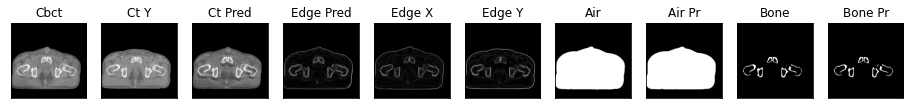

92it [00:35,  2.63it/s]

ssim score = 0.82598477602005
psnr score = 21.733543395996094
snr score = 12.714815139770508
mae error = 0.044801462441682816
air dice score = 0.9982676074083421
bone dice score = 0.9097854833983282
contour dice score = 0.5881720185279846


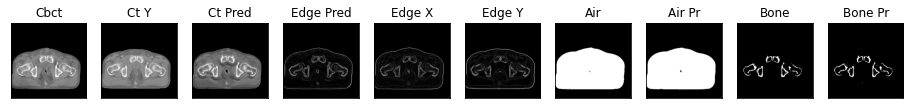

93it [00:36,  2.66it/s]

ssim score = 0.8266550898551941
psnr score = 21.51025390625
snr score = 12.607791900634766
mae error = 0.046485140919685364
air dice score = 0.9982073050345522
bone dice score = 0.8842105263174146
contour dice score = 0.5207100510597229


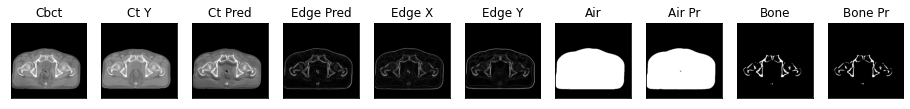

94it [00:36,  2.69it/s]

ssim score = 0.8297317624092102
psnr score = 21.529672622680664
snr score = 12.58897590637207
mae error = 0.0457698293030262
air dice score = 0.9986266026277152
bone dice score = 0.8832713754664198
contour dice score = 0.5220667123794556


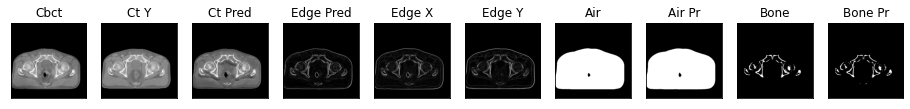

95it [00:36,  2.70it/s]

ssim score = 0.824117124080658
psnr score = 21.254594802856445
snr score = 12.21822738647461
mae error = 0.046031780540943146
air dice score = 0.9978390318862868
bone dice score = 0.8820584144661744
contour dice score = 0.4816414713859558


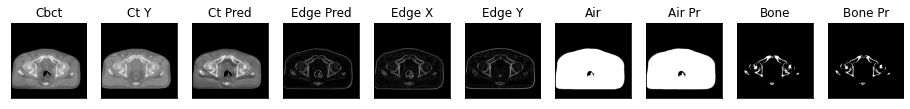

96it [00:37,  2.72it/s]

ssim score = 0.8296970725059509
psnr score = 21.581628799438477
snr score = 12.38550090789795
mae error = 0.04306875169277191
air dice score = 0.9979688230457998
bone dice score = 0.8960132890382722
contour dice score = 0.5043196678161621


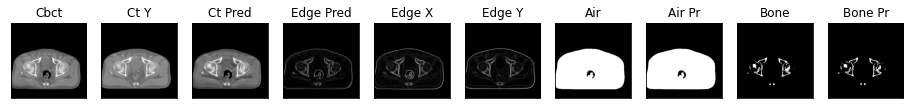

97it [00:37,  2.73it/s]

ssim score = 0.8290257453918457
psnr score = 21.68359375
snr score = 12.37104320526123
mae error = 0.04153529554605484
air dice score = 0.9977846554813505
bone dice score = 0.8978412374656155
contour dice score = 0.46521738171577454


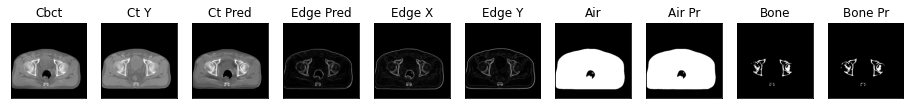

98it [00:38,  2.33it/s]

ssim score = 0.8243359327316284
psnr score = 21.695680618286133
snr score = 12.338035583496094
mae error = 0.04101194813847542
air dice score = 0.9981229046615916
bone dice score = 0.9074492099337722
contour dice score = 0.4564270079135895


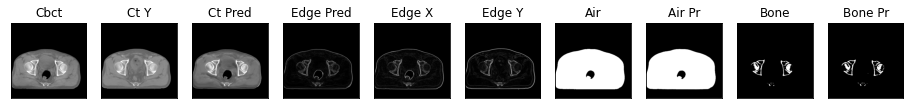

99it [00:38,  2.44it/s]

ssim score = 0.8187010884284973
psnr score = 21.445545196533203
snr score = 12.094573974609375
mae error = 0.04191825911402702
air dice score = 0.9978165221959566
bone dice score = 0.916516909003161
contour dice score = 0.4836244583129883


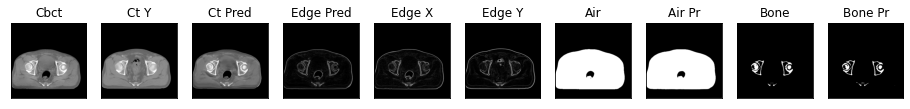

100it [00:38,  2.53it/s]

ssim score = 0.8230375647544861
psnr score = 21.274124145507812
snr score = 11.953254699707031
mae error = 0.04274599999189377
air dice score = 0.9977298897845059
bone dice score = 0.9165746727658638
contour dice score = 0.4665936529636383


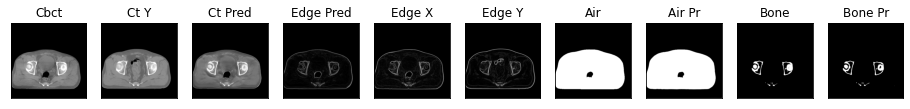

101it [00:39,  2.59it/s]

ssim score = 0.8290794491767883
psnr score = 21.732187271118164
snr score = 12.368731498718262
mae error = 0.04159991070628166
air dice score = 0.9973787357124684
bone dice score = 0.9119298245629486
contour dice score = 0.4556407332420349


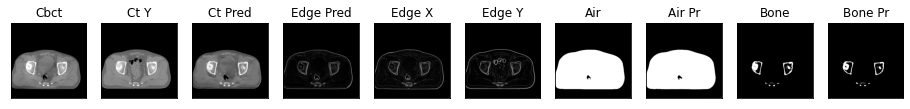

102it [00:39,  2.64it/s]

ssim score = 0.8291521668434143
psnr score = 22.040977478027344
snr score = 12.587319374084473
mae error = 0.03981544449925423
air dice score = 0.9974417376378182
bone dice score = 0.9131532931821809
contour dice score = 0.452850878238678


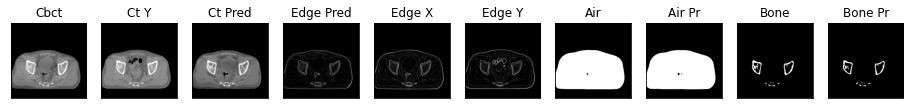

103it [00:39,  2.68it/s]

ssim score = 0.8317965865135193
psnr score = 21.95064353942871
snr score = 12.431259155273438
mae error = 0.03928578644990921
air dice score = 0.9978492472365346
bone dice score = 0.9306532663330522
contour dice score = 0.46871569752693176


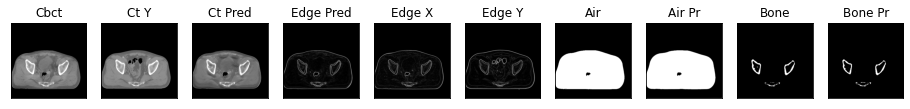

104it [00:40,  2.70it/s]

ssim score = 0.8283500671386719
psnr score = 21.85795783996582
snr score = 12.338271141052246
mae error = 0.03995675966143608
air dice score = 0.9976317248097841
bone dice score = 0.9156540386005065
contour dice score = 0.4810126721858978


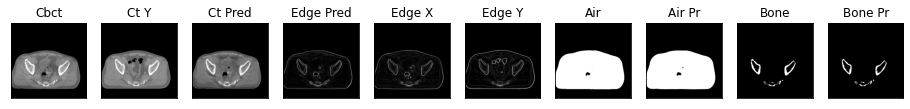

105it [00:40,  2.71it/s]

ssim score = 0.8227428197860718
psnr score = 21.526268005371094
snr score = 12.082744598388672
mae error = 0.041977979242801666
air dice score = 0.9977110885045798
bone dice score = 0.8803418803437066
contour dice score = 0.5646408796310425


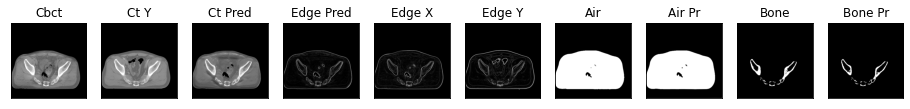

106it [00:41,  2.73it/s]

ssim score = 0.8290308117866516
psnr score = 21.58586883544922
snr score = 12.177932739257812
mae error = 0.041996631771326065
air dice score = 0.9979020979020997
bone dice score = 0.860215053765472
contour dice score = 0.6165745854377747


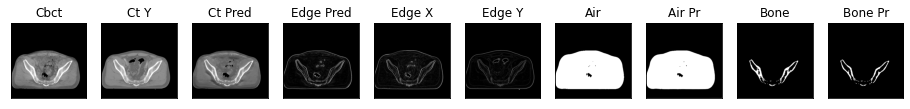

107it [00:41,  2.74it/s]

ssim score = 0.8307450413703918
psnr score = 21.899795532226562
snr score = 12.430157661437988
mae error = 0.04056781157851219
air dice score = 0.997486898420951
bone dice score = 0.8672376873681976
contour dice score = 0.6226415038108826


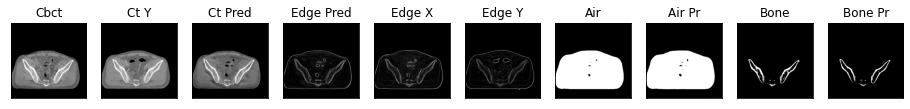

108it [00:42,  2.33it/s]

ssim score = 0.8244941234588623
psnr score = 21.902788162231445
snr score = 12.371889114379883
mae error = 0.04017862305045128
air dice score = 0.9972154482090686
bone dice score = 0.8734177215209902
contour dice score = 0.5701459050178528


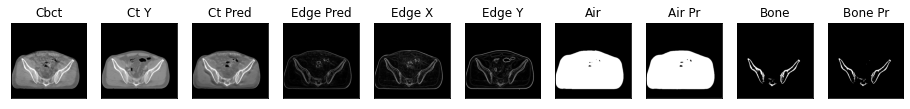

109it [00:42,  2.45it/s]

ssim score = 0.7664635181427002
psnr score = 20.44672966003418
snr score = 12.144036293029785
mae error = 0.053200505673885345
air dice score = 0.996727492619075
bone dice score = 0.9686700767273443
contour dice score = 0.3869257867336273


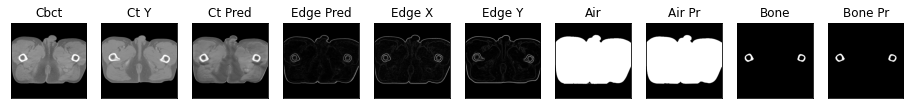

110it [00:42,  2.52it/s]

ssim score = 0.7566283345222473
psnr score = 20.14626693725586
snr score = 11.94786548614502
mae error = 0.05573410540819168
air dice score = 0.9966629326101075
bone dice score = 0.9564459930326236
contour dice score = 0.39750999212265015


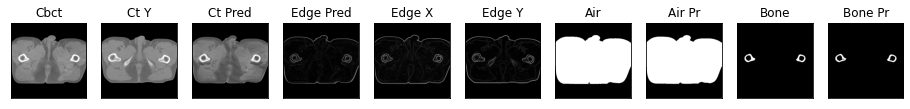

111it [00:43,  2.58it/s]

ssim score = 0.7510337233543396
psnr score = 19.682554244995117
snr score = 11.61210823059082
mae error = 0.05985970050096512
air dice score = 0.9967979412818829
bone dice score = 0.9302873292527016
contour dice score = 0.37634408473968506


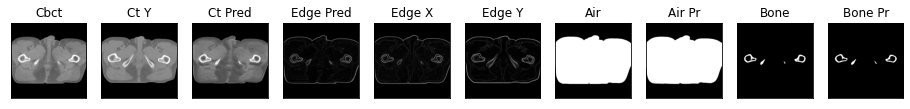

112it [00:43,  2.64it/s]

ssim score = 0.7430731654167175
psnr score = 19.360668182373047
snr score = 11.322509765625
mae error = 0.0634976476430893
air dice score = 0.9968716314383483
bone dice score = 0.9244206773632011
contour dice score = 0.3507194221019745


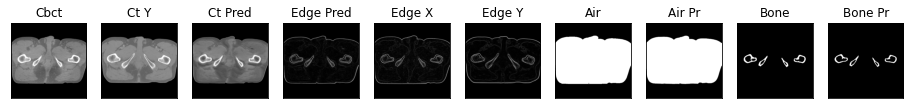

113it [00:43,  2.66it/s]

ssim score = 0.732720136642456
psnr score = 19.205209732055664
snr score = 11.197290420532227
mae error = 0.0651782900094986
air dice score = 0.9968854269536221
bone dice score = 0.9199115796646844
contour dice score = 0.34990957379341125


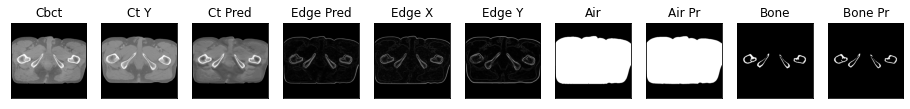

114it [00:44,  2.69it/s]

ssim score = 0.7296196818351746
psnr score = 19.10363006591797
snr score = 11.130127906799316
mae error = 0.0663304328918457
air dice score = 0.9970645450627296
bone dice score = 0.9215494791679435
contour dice score = 0.33740389347076416


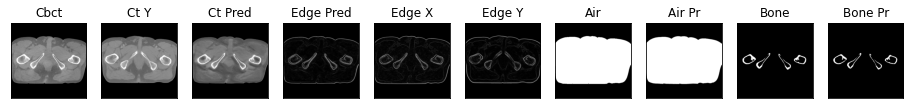

115it [00:44,  2.71it/s]

ssim score = 0.7191565036773682
psnr score = 18.852947235107422
snr score = 10.899757385253906
mae error = 0.06844814866781235
air dice score = 0.9966392505354581
bone dice score = 0.9055450443908376
contour dice score = 0.3360360264778137


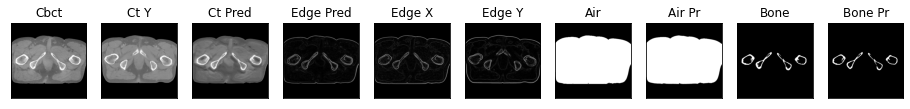

116it [00:44,  2.72it/s]

ssim score = 0.7231169939041138
psnr score = 18.79869270324707
snr score = 10.884574890136719
mae error = 0.06912025064229965
air dice score = 0.9965357833879827
bone dice score = 0.9063174557503768
contour dice score = 0.3375224471092224


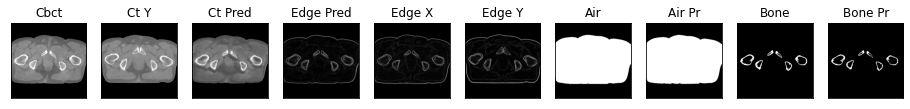

117it [00:45,  2.72it/s]

ssim score = 0.7192028164863586
psnr score = 18.742477416992188
snr score = 10.87703800201416
mae error = 0.07054723054170609
air dice score = 0.996217891170255
bone dice score = 0.9055710306419837
contour dice score = 0.33029118180274963


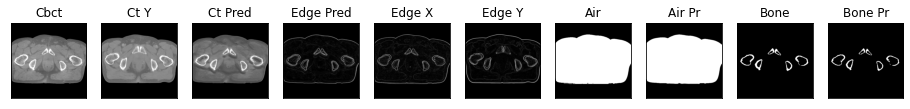

118it [00:45,  2.33it/s]

ssim score = 0.7114492654800415
psnr score = 18.540279388427734
snr score = 10.697450637817383
mae error = 0.07246360927820206
air dice score = 0.9963295741379731
bone dice score = 0.9101860527384529
contour dice score = 0.34778910875320435


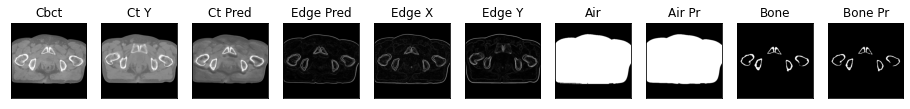

119it [00:46,  2.42it/s]

ssim score = 0.7004945278167725
psnr score = 18.44204330444336
snr score = 10.641995429992676
mae error = 0.07415235042572021
air dice score = 0.9967366128929801
bone dice score = 0.9058955502940809
contour dice score = 0.35093697905540466


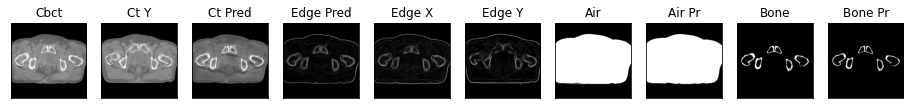

120it [00:46,  2.50it/s]

ssim score = 0.6963852643966675
psnr score = 18.270458221435547
snr score = 10.528746604919434
mae error = 0.07547611743211746
air dice score = 0.9968288317324036
bone dice score = 0.8904601831472068
contour dice score = 0.35133907198905945


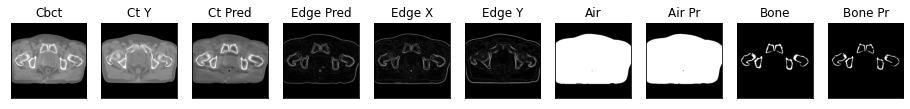

121it [00:46,  2.56it/s]

ssim score = 0.6950467824935913
psnr score = 18.34834098815918
snr score = 10.531258583068848
mae error = 0.07495790719985962
air dice score = 0.9974929561267336
bone dice score = 0.8451873702628079
contour dice score = 0.34655722975730896


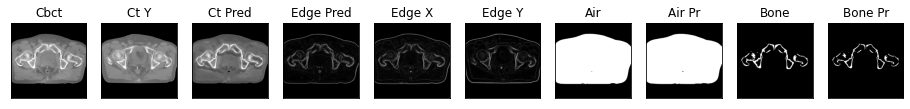

122it [00:47,  2.62it/s]

ssim score = 0.7005902528762817
psnr score = 18.586009979248047
snr score = 10.661710739135742
mae error = 0.0721544697880745
air dice score = 0.9974121868746133
bone dice score = 0.8321324873660378
contour dice score = 0.32951945066452026


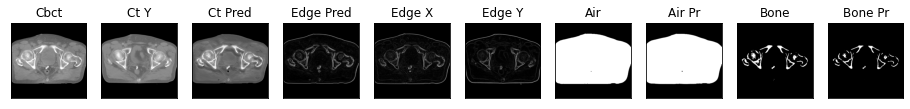

123it [00:47,  2.65it/s]

ssim score = 0.7064719200134277
psnr score = 19.02226448059082
snr score = 10.974875450134277
mae error = 0.06745735555887222
air dice score = 0.9973281431746742
bone dice score = 0.7895840229527795
contour dice score = 0.3288929760456085


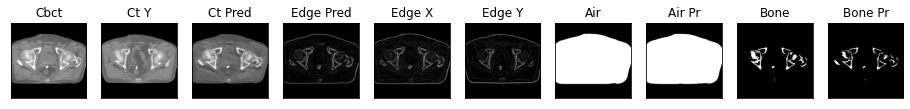

124it [00:48,  2.68it/s]

ssim score = 0.7137807011604309
psnr score = 19.43903160095215
snr score = 11.27921199798584
mae error = 0.06330252438783646
air dice score = 0.9975467134619062
bone dice score = 0.8161588497111016
contour dice score = 0.32948777079582214


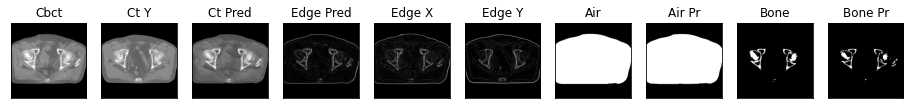

125it [00:48,  2.69it/s]

ssim score = 0.7139769792556763
psnr score = 19.618850708007812
snr score = 11.408384323120117
mae error = 0.061397626996040344
air dice score = 0.997557191812542
bone dice score = 0.859923920341688
contour dice score = 0.3200370967388153


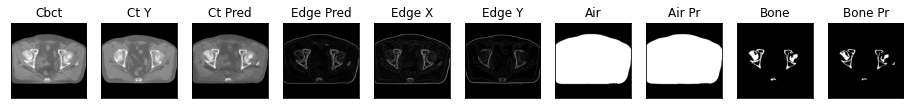

126it [00:48,  2.71it/s]

ssim score = 0.7130448222160339
psnr score = 19.525575637817383
snr score = 11.347264289855957
mae error = 0.06228262931108475
air dice score = 0.9973971042785114
bone dice score = 0.8757550633675736
contour dice score = 0.3229409158229828


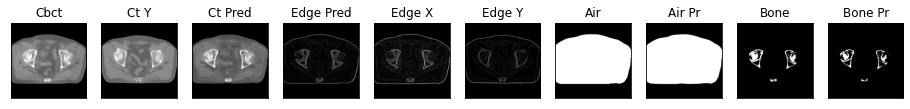

127it [00:49,  2.73it/s]

ssim score = 0.7121530771255493
psnr score = 19.381818771362305
snr score = 11.216984748840332
mae error = 0.06339061260223389
air dice score = 0.9974980900337685
bone dice score = 0.8784999366542696
contour dice score = 0.28477752208709717


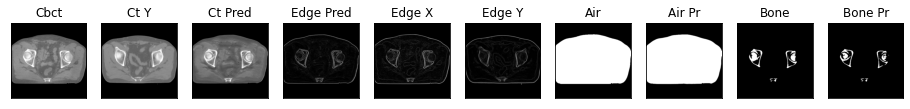

128it [00:49,  2.33it/s]

ssim score = 0.708527684211731
psnr score = 19.16398811340332
snr score = 10.857662200927734
mae error = 0.06431806832551956
air dice score = 0.9976147358920726
bone dice score = 0.8847995966740005
contour dice score = 0.2679245173931122


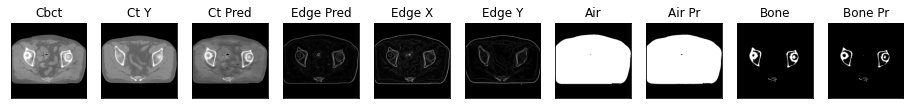

129it [00:50,  2.44it/s]

ssim score = 0.7226240038871765
psnr score = 19.37564468383789
snr score = 11.010009765625
mae error = 0.061809077858924866
air dice score = 0.9976322020520929
bone dice score = 0.9050487664959115
contour dice score = 0.29314419627189636


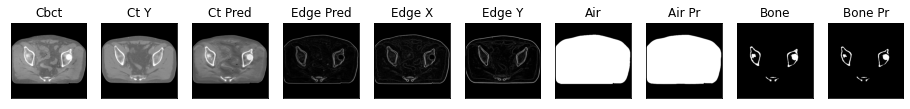

130it [00:50,  2.52it/s]

ssim score = 0.7184321880340576
psnr score = 19.546600341796875
snr score = 11.206613540649414
mae error = 0.06043938919901848
air dice score = 0.9975850271684458
bone dice score = 0.9115391808507286
contour dice score = 0.2765151560306549


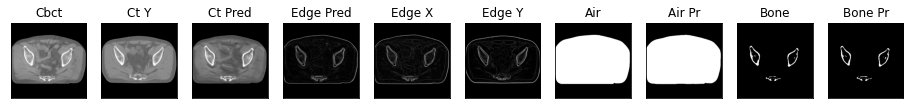

131it [00:50,  2.58it/s]

ssim score = 0.7140934467315674
psnr score = 19.31165885925293
snr score = 11.044485092163086
mae error = 0.06181906908750534
air dice score = 0.9971434692565896
bone dice score = 0.9154121863814442
contour dice score = 0.29004740715026855


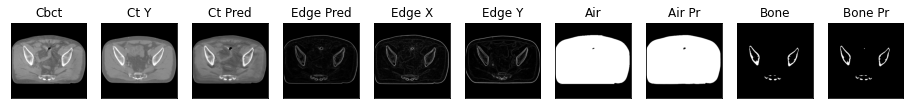

132it [00:51,  2.63it/s]

ssim score = 0.7064307928085327
psnr score = 18.8048095703125
snr score = 10.666865348815918
mae error = 0.0657653659582138
air dice score = 0.9971198812025861
bone dice score = 0.9108334759556592
contour dice score = 0.34795042872428894


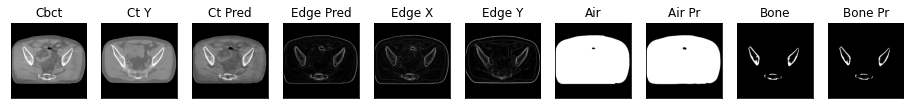

133it [00:51,  2.67it/s]

ssim score = 0.700928807258606
psnr score = 18.597557067871094
snr score = 10.493573188781738
mae error = 0.06768063455820084
air dice score = 0.9969165542493755
bone dice score = 0.8965191368735782
contour dice score = 0.33397313952445984


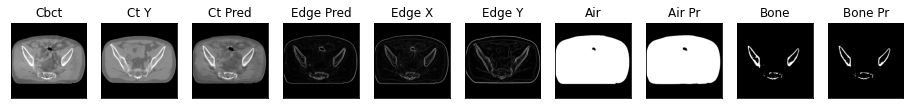

134it [00:51,  2.69it/s]

ssim score = 0.6933481097221375
psnr score = 18.596195220947266
snr score = 10.462425231933594
mae error = 0.06905314326286316
air dice score = 0.997186228217423
bone dice score = 0.8700370566454468
contour dice score = 0.31406551599502563


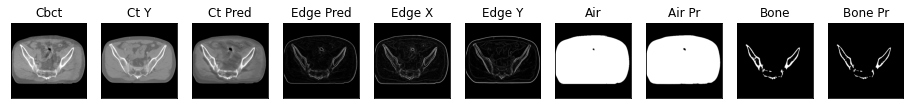

135it [00:52,  2.70it/s]

ssim score = 0.6927281022071838
psnr score = 18.85307502746582
snr score = 10.655926704406738
mae error = 0.06692706793546677
air dice score = 0.9972443782287728
bone dice score = 0.8657549539510779
contour dice score = 0.341227650642395


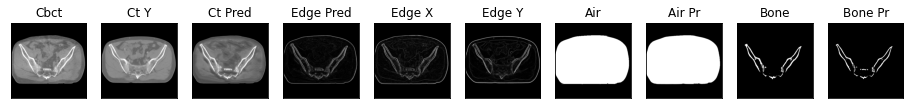

136it [00:52,  2.72it/s]

ssim score = 0.7856084108352661
psnr score = 19.78009605407715
snr score = 11.257486343383789
mae error = 0.057833168655633926
air dice score = 0.9982789317507431
bone dice score = 0.8938759984798544
contour dice score = 0.4959758520126343


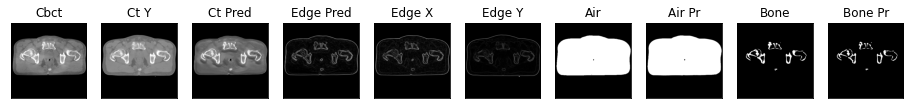

137it [00:53,  2.73it/s]

ssim score = 0.7908136248588562
psnr score = 19.80010986328125
snr score = 11.317511558532715
mae error = 0.05790265277028084
air dice score = 0.9982755544984255
bone dice score = 0.885646687698664
contour dice score = 0.48637738823890686


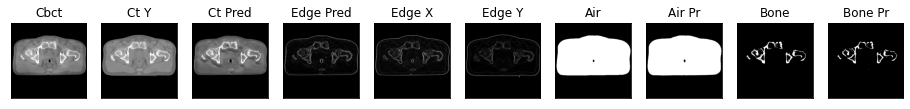

138it [00:53,  2.33it/s]

ssim score = 0.7957924008369446
psnr score = 19.921207427978516
snr score = 11.446398735046387
mae error = 0.057489924132823944
air dice score = 0.9980354804143365
bone dice score = 0.8818318113686543
contour dice score = 0.46504560112953186


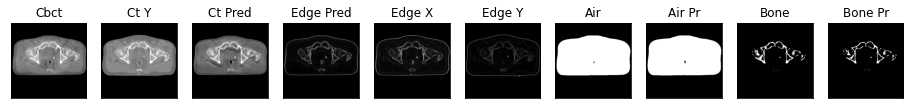

139it [00:53,  2.44it/s]

ssim score = 0.7989259362220764
psnr score = 20.030223846435547
snr score = 11.49699592590332
mae error = 0.05610156059265137
air dice score = 0.9979910530914646
bone dice score = 0.8872821174966136
contour dice score = 0.4123920798301697


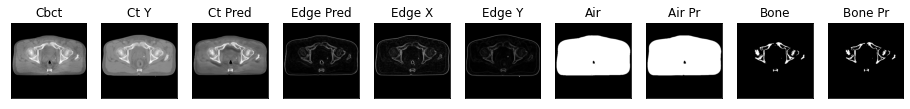

140it [00:54,  2.52it/s]

ssim score = 0.8063294291496277
psnr score = 20.396705627441406
snr score = 11.707849502563477
mae error = 0.05254894495010376
air dice score = 0.9977968616519058
bone dice score = 0.8935978358897866
contour dice score = 0.39653414487838745


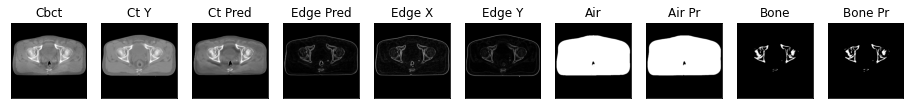

141it [00:54,  2.58it/s]

ssim score = 0.810316801071167
psnr score = 20.510395050048828
snr score = 11.800738334655762
mae error = 0.051778774708509445
air dice score = 0.9979794641448791
bone dice score = 0.9048983099412075
contour dice score = 0.45012786984443665


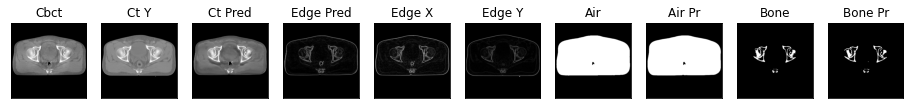

142it [00:55,  2.63it/s]

ssim score = 0.8051461577415466
psnr score = 20.449249267578125
snr score = 11.72396183013916
mae error = 0.051922645419836044
air dice score = 0.9976716674327325
bone dice score = 0.9067005937248134
contour dice score = 0.47946611046791077


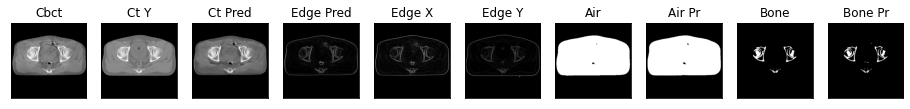

143it [00:55,  2.67it/s]

ssim score = 0.7954642176628113
psnr score = 20.134050369262695
snr score = 11.418127059936523
mae error = 0.05363820493221283
air dice score = 0.9977372312489139
bone dice score = 0.8903002309484657
contour dice score = 0.5046343803405762


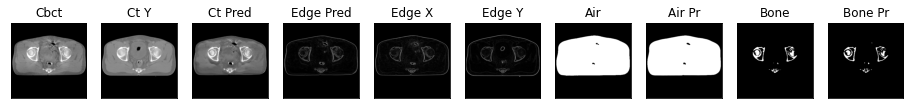

144it [00:55,  2.70it/s]

ssim score = 0.7904949188232422
psnr score = 19.895885467529297
snr score = 11.235742568969727
mae error = 0.055406682193279266
air dice score = 0.9974303581580463
bone dice score = 0.8996400287991413
contour dice score = 0.4756980240345001


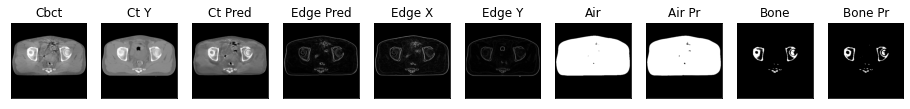

145it [00:56,  2.71it/s]

ssim score = 0.7935264706611633
psnr score = 19.820980072021484
snr score = 11.138906478881836
mae error = 0.055825188755989075
air dice score = 0.997197215494526
bone dice score = 0.8771564544932011
contour dice score = 0.4776739478111267


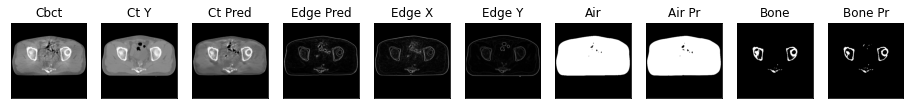

146it [00:56,  2.70it/s]

ssim score = 0.7944693565368652
psnr score = 19.63429832458496
snr score = 10.881452560424805
mae error = 0.055756378918886185
air dice score = 0.9971724211716897
bone dice score = 0.871669118851207
contour dice score = 0.5164319276809692


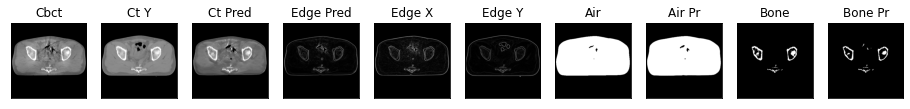

147it [00:56,  2.71it/s]

ssim score = 0.7958119511604309
psnr score = 19.91622543334961
snr score = 11.119487762451172
mae error = 0.05416545271873474
air dice score = 0.9972466539196961
bone dice score = 0.9004966603887566
contour dice score = 0.5172774791717529


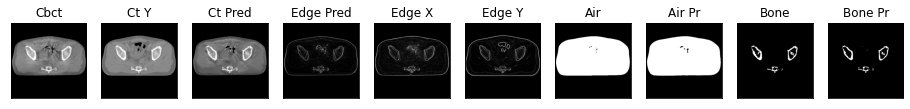

148it [00:57,  2.31it/s]

ssim score = 0.7941375970840454
psnr score = 19.95844268798828
snr score = 11.160604476928711
mae error = 0.05374263972043991
air dice score = 0.9975593657420928
bone dice score = 0.8977329974828256
contour dice score = 0.5323513746261597


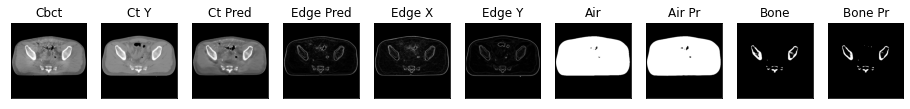

149it [00:57,  2.41it/s]

ssim score = 0.7877433896064758
psnr score = 19.78768539428711
snr score = 11.00320816040039
mae error = 0.05476851761341095
air dice score = 0.9970153858018763
bone dice score = 0.8782051282070801
contour dice score = 0.5060622096061707


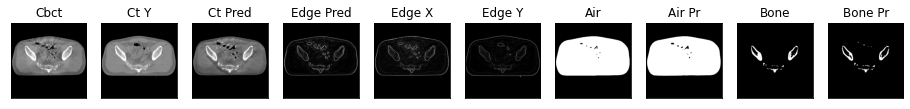

150it [00:58,  2.50it/s]

ssim score = 0.7848486304283142
psnr score = 19.665321350097656
snr score = 10.93604850769043
mae error = 0.056217558681964874
air dice score = 0.9967776917118538
bone dice score = 0.8621553884730973
contour dice score = 0.5060750246047974


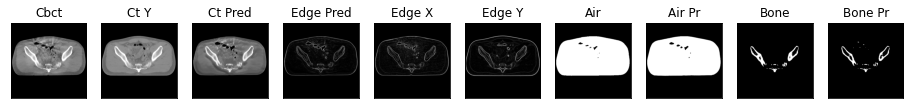

151it [00:58,  2.54it/s]

ssim score = 0.7856606245040894
psnr score = 19.510995864868164
snr score = 10.801091194152832
mae error = 0.05716841295361519
air dice score = 0.9968495382944077
bone dice score = 0.8538329519471706
contour dice score = 0.5275423526763916


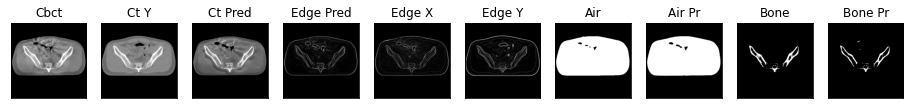

152it [00:58,  2.60it/s]

ssim score = 0.7889844179153442
psnr score = 19.66895866394043
snr score = 10.904314041137695
mae error = 0.05575517192482948
air dice score = 0.9968758479010839
bone dice score = 0.8590520590542494
contour dice score = 0.45246946811676025


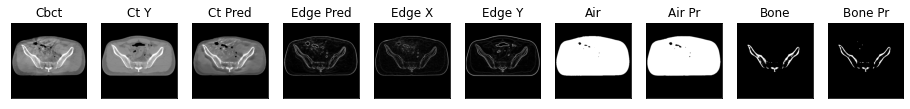

153it [00:59,  2.64it/s]

ssim score = 0.7919939160346985
psnr score = 19.95876121520996
snr score = 11.15776538848877
mae error = 0.054151494055986404
air dice score = 0.9970096064456174
bone dice score = 0.8650325783452524
contour dice score = 0.45178475975990295


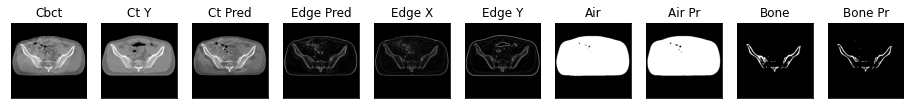

154it [00:59,  2.67it/s]

ssim score = 0.7947445511817932
psnr score = 20.093870162963867
snr score = 11.29294490814209
mae error = 0.05302346125245094
air dice score = 0.9969994650208975
bone dice score = 0.8398852223839328
contour dice score = 0.4633493721485138


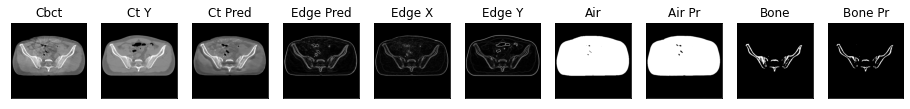

155it [01:00,  2.66it/s]

ssim score = 0.7886655330657959
psnr score = 20.088979721069336
snr score = 11.28663444519043
mae error = 0.053047679364681244
air dice score = 0.9972285836276853
bone dice score = 0.875733035466689
contour dice score = 0.4335664212703705


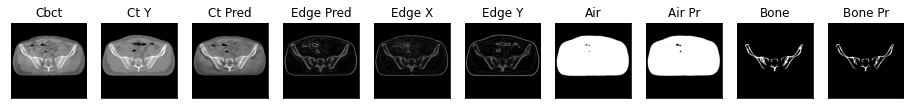

156it [01:00,  2.67it/s]

ssim score = 0.7816547155380249
psnr score = 19.735382080078125
snr score = 10.938074111938477
mae error = 0.05481092259287834
air dice score = 0.996493579354198
bone dice score = 0.8685888550059802
contour dice score = 0.4452871084213257


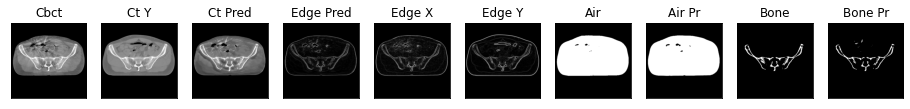

157it [01:00,  2.67it/s]

ssim score = 0.777600884437561
psnr score = 19.441625595092773
snr score = 10.627045631408691
mae error = 0.05583278462290764
air dice score = 0.995668825727022
bone dice score = 0.8418087054537003
contour dice score = 0.3901907503604889


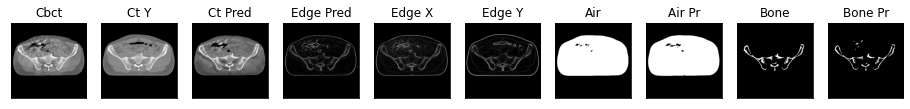

158it [01:01,  2.29it/s]

ssim score = 0.7723959684371948
psnr score = 19.355228424072266
snr score = 10.522026062011719
mae error = 0.055935222655534744
air dice score = 0.99588859103666
bone dice score = 0.8275954814439538
contour dice score = 0.4070214033126831


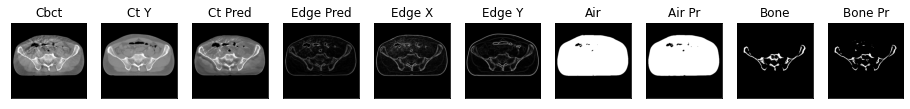

159it [01:01,  2.38it/s]

ssim score = 0.7626929879188538
psnr score = 19.21076011657715
snr score = 10.331619262695312
mae error = 0.056338775902986526
air dice score = 0.9953589695018032
bone dice score = 0.8177766124827245
contour dice score = 0.4050772488117218


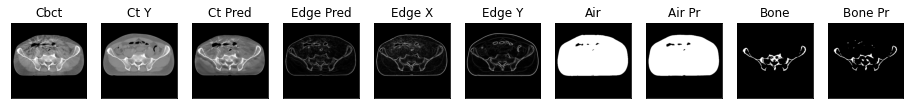

160it [01:02,  2.46it/s]

ssim score = 0.7614875435829163
psnr score = 19.248977661132812
snr score = 10.316038131713867
mae error = 0.055497873574495316
air dice score = 0.9949022064011838
bone dice score = 0.8309056364809259
contour dice score = 0.38200998306274414


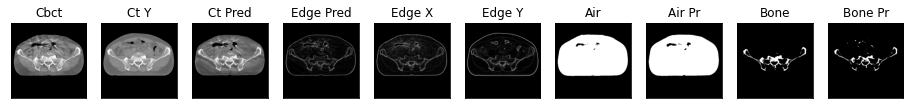

161it [01:02,  2.52it/s]

ssim score = 0.7589102387428284
psnr score = 19.077913284301758
snr score = 10.175437927246094
mae error = 0.05688512325286865
air dice score = 0.9948325145509743
bone dice score = 0.8533825338271417
contour dice score = 0.3953229486942291


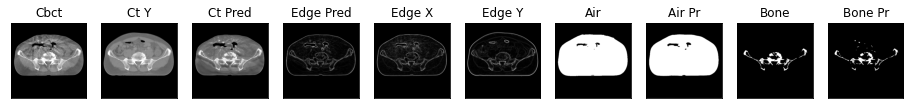

162it [01:02,  2.57it/s]

ssim score = 0.7523239254951477
psnr score = 19.007610321044922
snr score = 10.049909591674805
mae error = 0.05618097260594368
air dice score = 0.9950689391037956
bone dice score = 0.8469282395476648
contour dice score = 0.3915461599826813


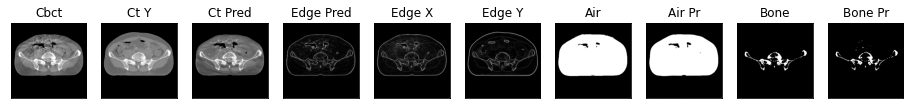

163it [01:03,  2.58it/s]

ssim score = 0.7622267603874207
psnr score = 19.66139793395996
snr score = 10.556163787841797
mae error = 0.05168895795941353
air dice score = 0.9952012519861745
bone dice score = 0.8644453365467089
contour dice score = 0.3266219198703766


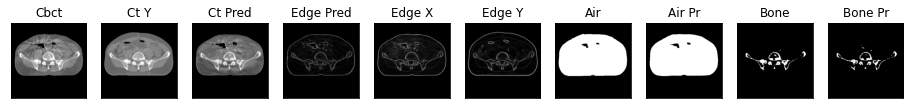

164it [01:03,  2.61it/s]

ssim score = 0.80940181016922
psnr score = 23.535511016845703
snr score = 13.916421890258789
mae error = 0.03089594841003418
air dice score = 0.9961699960888235
bone dice score = 0.9483465427726606
contour dice score = 0.49733397364616394


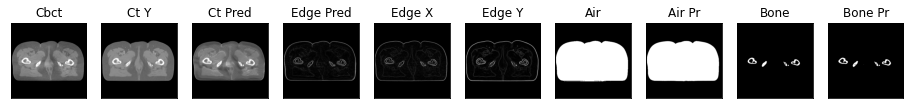

165it [01:04,  2.64it/s]

ssim score = 0.8138330578804016
psnr score = 23.520166397094727
snr score = 14.022090911865234
mae error = 0.03181329742074013
air dice score = 0.9965041883780779
bone dice score = 0.949278734296201
contour dice score = 0.5066798329353333


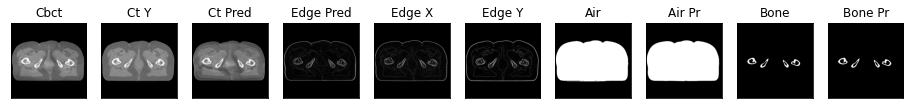

166it [01:04,  2.66it/s]

ssim score = 0.8116171956062317
psnr score = 23.424747467041016
snr score = 14.009589195251465
mae error = 0.032900143414735794
air dice score = 0.9966140201411213
bone dice score = 0.942093072226951
contour dice score = 0.50390625


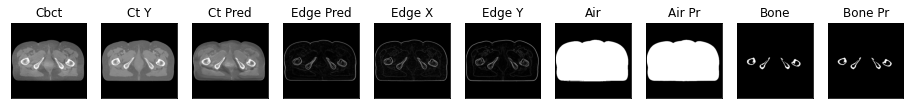

167it [01:04,  2.66it/s]

ssim score = 0.8062660694122314
psnr score = 23.241260528564453
snr score = 13.889547348022461
mae error = 0.0339079350233078
air dice score = 0.9968257189239355
bone dice score = 0.935860616505153
contour dice score = 0.505859375


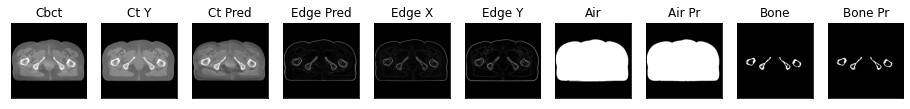

168it [01:05,  2.30it/s]

ssim score = 0.8049583435058594
psnr score = 23.088333129882812
snr score = 13.765082359313965
mae error = 0.03417466580867767
air dice score = 0.9967717473729847
bone dice score = 0.9294742626867655
contour dice score = 0.4702410101890564


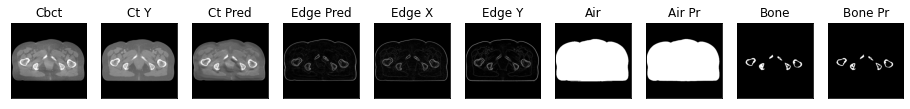

169it [01:05,  2.43it/s]

ssim score = 0.807257354259491
psnr score = 22.99264907836914
snr score = 13.692351341247559
mae error = 0.0345250628888607
air dice score = 0.996895774363852
bone dice score = 0.9358390280953713
contour dice score = 0.4956183135509491


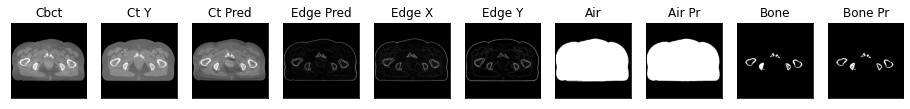

170it [01:06,  2.52it/s]

ssim score = 0.803257167339325
psnr score = 22.913280487060547
snr score = 13.644309043884277
mae error = 0.03508617728948593
air dice score = 0.9968242107229613
bone dice score = 0.9180759113130763
contour dice score = 0.44100579619407654


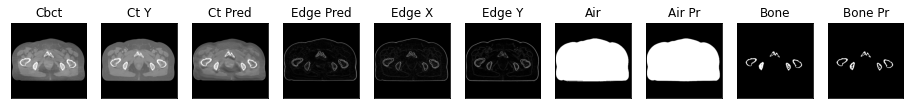

171it [01:06,  2.59it/s]

ssim score = 0.8038127422332764
psnr score = 22.624828338623047
snr score = 13.404221534729004
mae error = 0.03656822070479393
air dice score = 0.9962974124940828
bone dice score = 0.92836573074283
contour dice score = 0.4673248827457428


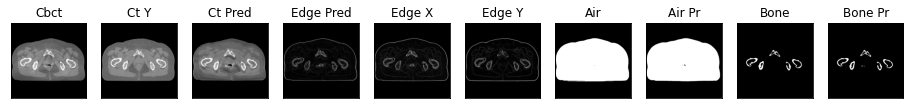

172it [01:06,  2.60it/s]

ssim score = 0.8017958402633667
psnr score = 22.4384765625
snr score = 13.260612487792969
mae error = 0.037278153002262115
air dice score = 0.9964529840886923
bone dice score = 0.9270429654603699
contour dice score = 0.4670831263065338


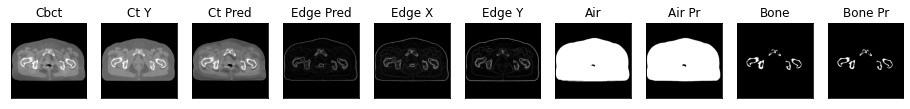

173it [01:07,  2.63it/s]

ssim score = 0.7993883490562439
psnr score = 22.093868255615234
snr score = 13.003705978393555
mae error = 0.03955943137407303
air dice score = 0.9962304792676386
bone dice score = 0.910669610008673
contour dice score = 0.4663551449775696


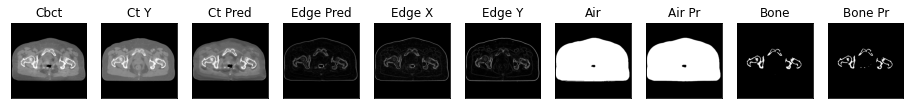

174it [01:07,  2.67it/s]

ssim score = 0.8036559820175171
psnr score = 22.367958068847656
snr score = 13.391070365905762
mae error = 0.04009709507226944
air dice score = 0.9957543528604542
bone dice score = 0.8886928022199837
contour dice score = 0.4330563247203827


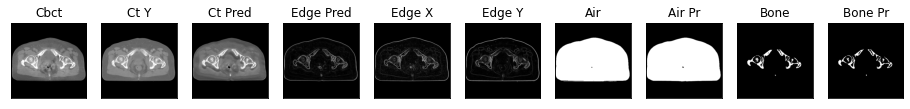

175it [01:07,  2.69it/s]

ssim score = 0.8070752620697021
psnr score = 22.348064422607422
snr score = 13.242627143859863
mae error = 0.03851046413183212
air dice score = 0.9952419169915191
bone dice score = 0.8986769385379555
contour dice score = 0.46118298172950745


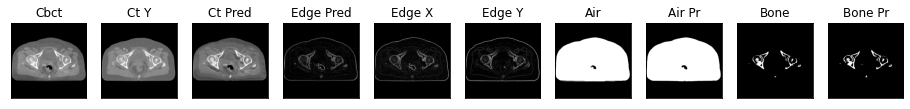

176it [01:08,  2.70it/s]

ssim score = 0.8095231652259827
psnr score = 22.671188354492188
snr score = 13.45632553100586
mae error = 0.03640107065439224
air dice score = 0.9955952815796856
bone dice score = 0.904673590506219
contour dice score = 0.47383177280426025


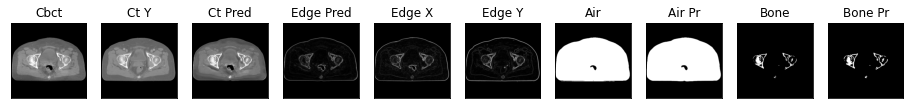

177it [01:08,  2.70it/s]

ssim score = 0.8125497698783875
psnr score = 22.8994083404541
snr score = 13.657421112060547
mae error = 0.03527219966053963
air dice score = 0.9956093695340251
bone dice score = 0.9183533447698395
contour dice score = 0.4814305305480957


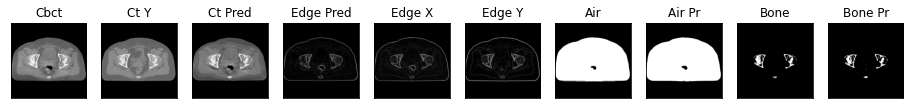

178it [01:09,  2.30it/s]

ssim score = 0.817348062992096
psnr score = 23.38300323486328
snr score = 14.133010864257812
mae error = 0.03427904471755028
air dice score = 0.9958166696160001
bone dice score = 0.9210032417689643
contour dice score = 0.46893975138664246


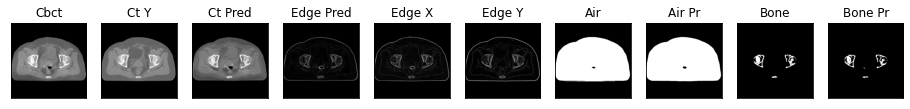

179it [01:09,  2.40it/s]

ssim score = 0.813110888004303
psnr score = 23.80155372619629
snr score = 14.585789680480957
mae error = 0.03339783102273941
air dice score = 0.9962114302552401
bone dice score = 0.9145056048199012
contour dice score = 0.44015079736709595


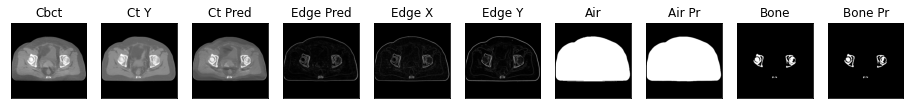

180it [01:09,  2.48it/s]

ssim score = 0.8094882965087891
psnr score = 23.427608489990234
snr score = 14.263335227966309
mae error = 0.03467031568288803
air dice score = 0.996672004455896
bone dice score = 0.9179779042531306
contour dice score = 0.439846009016037


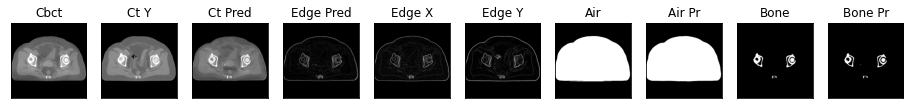

181it [01:10,  2.53it/s]

ssim score = 0.7964235544204712
psnr score = 22.943880081176758
snr score = 13.817166328430176
mae error = 0.03628524765372276
air dice score = 0.9966929710099924
bone dice score = 0.9259989249251748
contour dice score = 0.45045915246009827


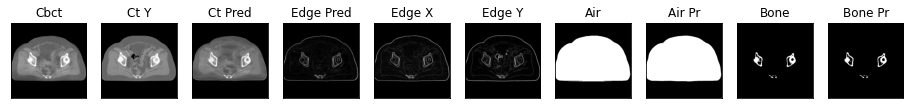

182it [01:10,  2.58it/s]

ssim score = 0.782025158405304
psnr score = 21.861183166503906
snr score = 12.662031173706055
mae error = 0.0391409769654274
air dice score = 0.9957219251336927
bone dice score = 0.9302120141358169
contour dice score = 0.436950147151947


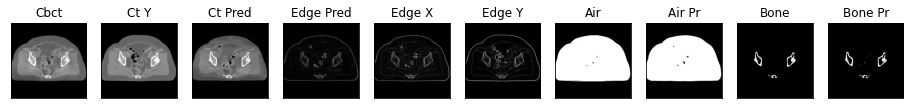

183it [01:11,  2.62it/s]

ssim score = 0.7741972208023071
psnr score = 21.559755325317383
snr score = 12.342613220214844
mae error = 0.04017398878931999
air dice score = 0.9961479986637332
bone dice score = 0.9224652087492277
contour dice score = 0.4644268751144409


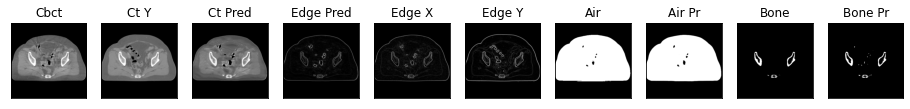

184it [01:11,  2.64it/s]

ssim score = 0.772283136844635
psnr score = 22.006694793701172
snr score = 12.85446548461914
mae error = 0.039114780724048615
air dice score = 0.9962299272288304
bone dice score = 0.9321851453190056
contour dice score = 0.45652174949645996


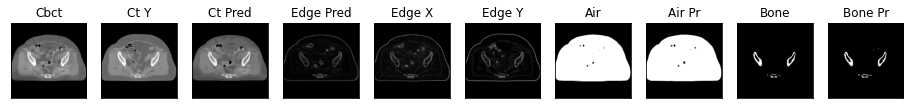

185it [01:11,  2.66it/s]

ssim score = 0.7754518985748291
psnr score = 22.1440486907959
snr score = 13.046913146972656
mae error = 0.03829357400536537
air dice score = 0.9959692782802281
bone dice score = 0.9212190914333674
contour dice score = 0.4681274890899658


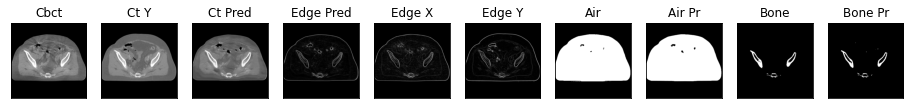

186it [01:12,  2.67it/s]

ssim score = 0.7760831713676453
psnr score = 21.683082580566406
snr score = 12.650375366210938
mae error = 0.04005240276455879
air dice score = 0.995836229437662
bone dice score = 0.8967867575479262
contour dice score = 0.4365781843662262


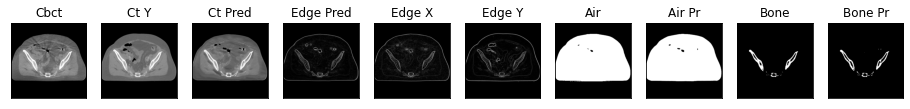

187it [01:12,  2.68it/s]

ssim score = 0.7706418037414551
psnr score = 21.505657196044922
snr score = 12.545812606811523
mae error = 0.04102068021893501
air dice score = 0.9960063582979756
bone dice score = 0.8884462151411516
contour dice score = 0.39664527773857117


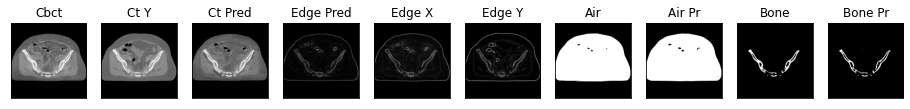

188it [01:13,  2.27it/s]

ssim score = 0.7704840898513794
psnr score = 21.485538482666016
snr score = 12.521401405334473
mae error = 0.041372183710336685
air dice score = 0.995510786491966
bone dice score = 0.8891603053452036
contour dice score = 0.40254029631614685


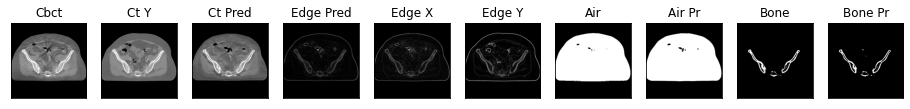

189it [01:13,  2.39it/s]

ssim score = 0.7681626081466675
psnr score = 21.71561050415039
snr score = 12.729293823242188
mae error = 0.04013974964618683
air dice score = 0.9963619475191602
bone dice score = 0.89764011799561
contour dice score = 0.42115476727485657


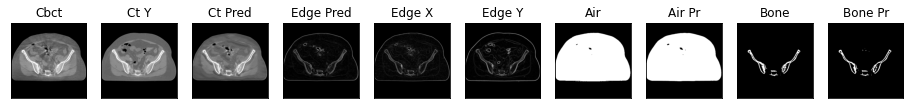

190it [01:13,  2.47it/s]

ssim score = 0.7764161229133606
psnr score = 22.367361068725586
snr score = 13.392682075500488
mae error = 0.038192976266145706
air dice score = 0.9965868125687134
bone dice score = 0.8873388931025422
contour dice score = 0.4050144553184509


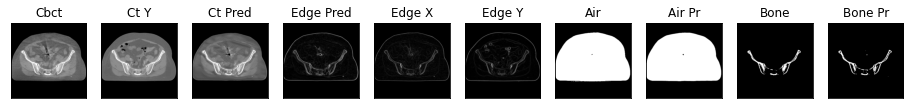

191it [01:14,  2.57it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [47]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [48]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:08, 21.75it/s]


(0.7954721510098243,
 20.87829173422609,
 11.882563655913188,
 0.048524108076594887,
 0.9967304724401667,
 0.8845918798626035,
 0.4504840899824472,
 0.493717277486911)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)